# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Import and Clean Wind Data

In [15]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [16]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [17]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [18]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [19]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [20]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [21]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [22]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


## Test Custom Extract Windows

In [82]:
# Test append behavior
a = train_dfs[0].copy().iloc[0:5]
b = train_dfs[1].copy().iloc[0:5]
a.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [83]:
b.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,15.63,1821,-104.5,8.33,6.72,89.5,8.86,0.3,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [84]:
a.append(b).head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0


In [23]:
df = train_dfs[train_index].copy()
start = df.iloc[0]['datetime']
end = start + pd.Timedelta('1 hour')
df[start:end]['datetime']

timestamp
2017-05-05 00:00:00   2017-05-05 00:00:00
2017-05-05 00:15:00   2017-05-05 00:15:00
2017-05-05 00:30:00   2017-05-05 00:30:00
2017-05-05 00:45:00   2017-05-05 00:45:00
2017-05-05 01:00:00   2017-05-05 01:00:00
Name: datetime, dtype: datetime64[ns]

In [24]:
df[start:end]['Temp C']

timestamp
2017-05-05 00:00:00    15.02
2017-05-05 00:15:00    14.99
2017-05-05 00:30:00    14.96
2017-05-05 00:45:00    14.95
2017-05-05 01:00:00    14.92
Name: Temp C, dtype: float64

In [25]:
# Test Timedelta math with separation set to 0
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')
x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
print("x_end equal: {} [old: {}, new:{}]".format(
    x_end == new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end equal: True [old: 2017-05-08 00:00:00, new:2017-05-08 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [68]:
# Test Timedelta math with separation set to 1 day
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta('1 day')
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')

x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# Short the new x window so that separation + x_win = old x_win
x_win = pd.Timedelta('2 days')

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
# the new x end should be a day soon due to separation
print("x_end NOT equal: {} [old: {}, new:{}]".format(
    x_end != new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end NOT equal: True [old: 2017-05-08 00:00:00, new:2017-05-07 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [27]:
# Verify we can add slices to a dataframe
time = df['datetime'][start:end]
temp = df['Temp C'][start:end]
a = pd.DataFrame()
a['datetime'] = time
a['Temp C'] = temp
a

,datetime,Temp C
timestamp,,
2017-05-05 00:00:00,2017-05-05 00:00:00,15.02
2017-05-05 00:15:00,2017-05-05 00:15:00,14.99
2017-05-05 00:30:00,2017-05-05 00:30:00,14.96
2017-05-05 00:45:00,2017-05-05 00:45:00,14.95
2017-05-05 01:00:00,2017-05-05 01:00:00,14.92


In [28]:
parameters = {'Temp C': {'x_win_size':pd.Timedelta('7 days'), 'separation':pd.Timedelta('21 days')},
              'pH': {'x_win_size':pd.Timedelta('4 days'), 'separation':pd.Timedelta(0)}}

In [29]:
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
param = {'x_win_size':x_win, 'separation':separation}
parameters = {'Temp C': param,
              'datetime': param}
original = hf.data_window_reduction(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                 custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...


In [30]:
print(original.shape)
print(custom.shape)
print(original.shape == custom.shape)

(332, 17)
(332, 17)
True


In [31]:
# Check that each value is the same
original.equals(custom)

True

In [32]:
# Test concat behavior
a = pd.DataFrame({'a':range(5)})
b = pd.DataFrame({'b': range(80)})
pd.concat([a, b], axis='columns')

,a,b
0,0.0,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4
5,NaN,5
6,NaN,6
7,NaN,7
8,NaN,8
9,NaN,9


In [33]:
# Test quantile behavior
print("a quantile:", a.quantile(0.95))
print("b quantile:", b.quantile(0.95))
print("combined quantile:", pd.concat([a, b], axis='columns').quantile(0.95))

a quantile: a    3.8
Name: 0.95, dtype: float64
b quantile: b    75.05
Name: 0.95, dtype: float64
combined quantile: a     3.80
b    75.05
Name: 0.95, dtype: float64


As we can see NaNs are ignored in quantile calcuations, so extracting from dataframes that contain series of different lengths should produce the same results.

In [34]:
# Now we will pass different custom parameters, 
# and check that the targets are the same 
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
parameters = {'Temp C': {'x_win_size':pd.Timedelta('2 day'), 'separation':pd.Timedelta('1 day')},
              'pH': {'x_win_size':pd.Timedelta('2 days'), 'separation':pd.Timedelta(0)}}
original = hf.data_window_reduction(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...


In [35]:
# The pH and Temp C columns should not match,
# but every other column should match since x window in original is not smaller
# than the maximum x window + separation value in the new custom df.
print(original.shape)
print("shape matches:", original.shape == custom.shape)
for col in original.columns:
    if not np.equal(original[col].values, custom[col].values).all():
        print("original does not match at:", col)

(332, 17)
shape matches: True
original does not match at: Temp C
original does not match at: pH


## Optimal Window Size For Individual Features

In [106]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
window_sizes = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_x_windows = dict()

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:
    
    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.data_window_reduction(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    train = train.append(hf.data_window_reduction(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window))
    print("Windowizing 2018 data set:", test_index)
    test = hf.data_window_reduction(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    test = test.append(hf.data_window_reduction(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    window_sizes.append(current_x_window)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window <= max_x_window_size_for_use:
                print("Updating best accuracy and window size.")
                best_accuracies[col] = accuracy
                best_x_windows[col] = current_x_window
        accuracies[col].append(accuracy)
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5869565217391305
recall 0.45985401459854014
precision 0.75

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.4101449275362319
recall 0.012165450121654502
precision 0.8333333333333334

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6217391304347826
recall 0.45012165450121655
precision 0.8409090909090909

Updating best accuracy and window size.
Training model on: ODOSat%
accuracy 0.6594202898550725
recall 0.506082

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4043478260869565
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4043478260869565
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4043478260869565
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4043478260869565
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4043478260869565
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.591304347826087
recall 0.9829683698296837
precision 0.5949926362297496

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.636231884057971
recall 0.45985401459854014
precision 0.8669724770642202

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4043478260869565
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.5942028985507246
recall 0.40145985401459855
precision 0.8291457286432161

Updating best accuracy and window size.
current x window 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6151603498542274
recall 0.524390243902439
precision 0.7570422535211268

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.46647230320699706
recall 0.24146341463414633
precision 0.6428571428571429

Updating

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40233236151603496
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40233236151603496
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40233236151603496
recall 0.0
precision 0.0

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40233236151603496
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40233236151603496
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5962099125364432
recall 0.9878048780487805
precision 0.5982274741506647

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6763848396501457
recall 0.5414634146341464
precision 0.8671875

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40233236151603496
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6137026239067055
recall 0.4219512195121951
precision 0.8606965174129353

Updating best accuracy and window size.
current x window 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5833333333333334
recall 0.491566265060241
precision 0.7338129496402878

Training model on: Wind Speed
accuracy 0.47076023391812866
recall 0.2216867469879518
precision 0.7022900763358778

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.64912280

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3932748538011696
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3932748538011696
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3932748538011696
recall 0.0
precision 0.0

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3932748538011696
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3932748538011696
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6096491228070176
recall 0.9927710843373494
precision 0.6094674556213018

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6710526315789473
recall 0.5397590361445783
precision 0.8682170542635659

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3932748538011696
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6125730994152047
recall 0.41927710843373495
precision 0.8787878787878788

current x window 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5470588235294118
recall 0.44878048780487806
precision 0.6917293233082706

Training model on: Wind Speed
accuracy 0.5220588235294118
recall 0.3097560975609756
precision 0.7514792899408284

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6661764705882353
recall 0.5390243902439025
prec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39705882352941174
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39705882352941174
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.39558823529411763
recall 0.0
precision 0.0

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39705882352941174
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39705882352941174
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5985294117647059
recall 0.9902439024390244
precision 0.6014814814814815

Training model on: TMIN
accuracy 0.6941176470588235
recall 0.5902439024390244
precision 0.8581560283687943

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39705882352941174
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6147058823529412
recall 0.4268292682926829
precision 0.8663366336633663

Updating best accuracy and window size.
current x window 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5532544378698225
recall 0.47044334975369456
precision 0.6870503597122302

Training model on: Wind Speed
accuracy 0.5399408284023669
recall 0.3374384236453202
precision 0.7653631284916201

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6582840

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3994082840236686
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3994082840236686
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.39644970414201186
recall 0.0024630541871921183
precision 0.25

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3994082840236686
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3994082840236686
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.599112426035503
recall 0.9926108374384236
precision 0.6005961251862891

Training model on: TMIN
accuracy 0.7100591715976331
recall 0.625615763546798
precision 0.8523489932885906

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3994082840236686
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6183431952662722
recall 0.42857142857142855
precision 0.87

Updating best accuracy and window size.
current x window 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5601783060921248
recall 0.4853658536585366
precision 0.7007042253521126

Training model on: Wind Speed
accuracy 0.5616641901931649
recall 0.4024390243902439
precision 0.7674418604651163

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6612184249628529
recal

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39078751857355126
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39078751857355126
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3848439821693908
recall 0.007317073170731708
precision 0.3

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39078751857355126
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39078751857355126
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6092124814264487
recall 0.9951219512195122
precision 0.6098654708520179

Training model on: TMIN
accuracy 0.6701337295690936
recall 0.526829268292683
precision 0.8852459016393442

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39078751857355126
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6225854383358098
recall 0.43902439024390244
precision 0.8823529411764706

Updating best accuracy and window size.
current x window 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.564179104477612
recall 0.4951219512195122
precision 0.7048611111111112

Training model on: Wind Speed
accuracy 0.582089552238806
recall 0.4024390243902439
precision 0.825

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6686567164179105
recal

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.3641791044776119
recall 0.012195121951219513
precision 0.19230769230769232

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6074626865671642
recall 0.9902439024390244
precision 0.6105263157894737

Training model on: TMIN
accuracy 0.6746268656716418
recall 0.5390243902439025
precision 0.884

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3880597014925373
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6283582089552239
recall 0.44634146341463415
precision 0.8926829268292683

Updating best accuracy and window size.
current x window 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5780780780780781
recall 0.42606516290726815
precision 0.7657657657657657

Training model on: Wind Speed
accuracy 0.5840840840840841
recall 0.39598997493734334
precision 0.8144329896907216

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.678678

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.34234234234234234
recall 0.03258145363408521
precision 0.2

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4099099099099099
recall 0.022556390977443608
precision 0.75

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5930930930930931
recall 0.9899749373433584
precision 0.5966767371601208

Training model on: TMIN
accuracy 0.6921921921921922
recall 0.5639097744360902
precision 0.87890625

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4009009009009009
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6471471471471472
recall 0.46365914786967416
precision 0.8980582524271845

Updating best accuracy and window size.
current x window 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5906344410876133
recall 0.44862155388471175
precision 0.7782608695652173

Training model on: Wind Speed
accuracy 0.56797583081571
recall 0.40852130325814534
precision 0.7652582159624414

Training model on: ODO (mg/L)
accuracy 0.6918429003021148
recall 0.5939849624060151
preci

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3972809667673716
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3972809667673716
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.30513595166163143
recall 0.03258145363408521
precision 0.14942528735632185

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3972809667673716
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4093655589123867
recall 0.03007518796992481
precision 0.75

Training model on: pH (mV)
accuracy 0.5996978851963746
recall 0.9949874686716792
precision 0.6015151515151516

Training model on: TMIN
accuracy 0.6963746223564955
recall 0.5764411027568922
precision 0.8778625954198473

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3972809667673716
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6465256797583081
recall 0.48120300751879697
precision 0.8767123287671232

current x window 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5833333333333334
recall 0.45185185185185184
precision 0.7754237288135594

Training model on: Wind Speed
accuracy 0.6015151515151516
recall 0.42962962962962964
precision 0.8446601941747572

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6742424242424242
recall 0.5604938271604938
pr

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38636363636363635
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38636363636363635
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.29545454545454547
recall 0.03950617283950617
precision 0.17391304347826086

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38636363636363635
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4
recall 0.027160493827160494
precision 0.8461538461538461

Training model on: pH (mV)
accuracy 0.6090909090909091
recall 0.9925925925925926
precision 0.6118721461187214

Training model on: TMIN
accuracy 0.6833333333333333
recall 0.5703703703703704
precision 0.868421052631579

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38636363636363635
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6424242424242425
recall 0.45185185185185184
precision 0.9289340101522843

current x window 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5990853658536586
recall 0.47341772151898737
precision 0.7727272727272727

Training model on: Wind Speed
accuracy 0.6310975609756098
recall 0.45569620253164556
precision 0.8695652173913043

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6737804878048781
recall 0.5645569620253165
p

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3978658536585366
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3978658536585366
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.29878048780487804
recall 0.05822784810126582
precision 0.2072072072072072

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3978658536585366
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4146341463414634
recall 0.04050632911392405
precision 0.7619047619047619

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5975609756097561
recall 0.9924050632911392
precision 0.6003062787136294

Training model on: TMIN
accuracy 0.6996951219512195
recall 0.5974683544303797
precision 0.8613138686131386

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3978658536585366
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6615853658536586
recall 0.47341772151898737
precision 0.9303482587064676

Updating best accuracy and window size.
current x window 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6058282208588958
recall 0.4910025706940874
precision 0.764

Training model on: Wind Speed
accuracy 0.6349693251533742
recall 0.4961439588688946
precision 0.8212765957446808

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.6794478527607362
rec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40337423312883436
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40337423312883436
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2776073619631902
recall 0.06426735218508997
precision 0.1893939393939394

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40337423312883436
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4371165644171779
recall 0.07712082262210797
precision 0.7894736842105263

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5920245398773006
recall 0.9922879177377892
precision 0.5947611710323575

Training model on: TMIN
accuracy 0.7070552147239264
recall 0.6143958868894601
precision 0.8535714285714285

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40337423312883436
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6687116564417178
recall 0.4704370179948586
precision 0.9481865284974094

Updating best accuracy and window size.
current x window 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6101694915254238
recall 0.49363867684478374
precision 0.782258064516129

Training model on: Wind Speed
accuracy 0.6440677966101694
recall 0.49363867684478374
precision 0.8584070796460177

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.667180

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39445300462249616
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39445300462249616
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2588597842835131
recall 0.04834605597964377
precision 0.15079365079365079

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39445300462249616
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.41910631741140214
recall 0.09669211195928754
precision 0.6333333333333333

Training model on: pH (mV)
accuracy 0.6024653312788906
recall 0.9949109414758269
precision 0.6043276661514683

Training model on: TMIN
accuracy 0.7087827426810478
recall 0.6208651399491094
precision 0.8591549295774648

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39445300462249616
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.662557781201849
recall 0.4631043256997455
precision 0.9578947368421052

current x window 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6114551083591331
recall 0.5012722646310432
precision 0.7817460317460317

Training model on: Wind Speed
accuracy 0.6842105263157895
recall 0.5419847328244275
precision 0.8987341772151899

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.673374613003096
recall 0.5801526717557252
precis

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39164086687306504
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39164086687306504
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.24148606811145512
recall 0.05343511450381679
precision 0.1510791366906475

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39164086687306504
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4071207430340557
recall 0.1297709923664122
precision 0.5543478260869565

Training model on: pH (mV)
accuracy 0.6037151702786377
recall 0.9923664122137404
precision 0.6065318818040435

Training model on: TMIN
accuracy 0.7198142414860681
recall 0.6412213740458015
precision 0.863013698630137

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39164086687306504
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6702786377708978
recall 0.4732824427480916
precision 0.96875

Updating best accuracy and window size.
current x window 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6261682242990654
recall 0.5211640211640212
precision 0.76953125

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6947040498442367
recall 0.5740740740740741
precision 0.8611111111111112

Updating best accuracy and window size.
Training model on: ODO (mg/

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.411214953271028
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.411214953271028
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.24299065420560748
recall 0.042328042328042326
precision 0.11428571428571428

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.411214953271028
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.40498442367601245
recall 0.12698412698412698
precision 0.48

Training model on: pH (mV)
accuracy 0.5841121495327103
recall 0.9920634920634921
precision 0.5868544600938967

Training model on: TMIN
accuracy 0.7476635514018691
recall 0.6798941798941799
precision 0.8624161073825504

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.411214953271028
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6915887850467289
recall 0.4973544973544973
precision 0.9591836734693877

Updating best accuracy and window size.
current x window 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.64576802507837
recall 0.5423280423280423
precision 0.7945736434108527

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.664576802507837
recall 0.5740740740740741
precision 0.8037037037037037

Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40752351097178685
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40752351097178685
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.23667711598746083
recall 0.047619047619047616
precision 0.12413793103448276

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40752351097178685
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3793103448275862
recall 0.18253968253968253
precision 0.4423076923076923

Training model on: pH (mV)
accuracy 0.5909090909090909
recall 0.9973544973544973
precision 0.5918367346938775

Training model on: TMIN
accuracy 0.7617554858934169
recall 0.701058201058201
precision 0.8717105263157895

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40752351097178685
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6974921630094044
recall 0.5079365079365079
precision 0.964824120603015

Updating best accuracy and window size.
current x window 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6305031446540881
recall 0.535064935064935
precision 0.7862595419847328

Training model on: Wind Speed
accuracy 0.660377358490566
recall 0.535064935064935
precision 0.8477366255144033

Training model on: ODO (mg/L)
accuracy 0.6509433962264151
recall 0.5558441558441558
precisio

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.710691823899371
recall 0.8415584415584415
precision 0.7248322147651006

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.22012578616352202
recall 0.03896103896103896
precision 0.10638297872340426

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3757861635220126
recall 0.16363636363636364
precision 0.45652173913043476

Training model on: pH (mV)
accuracy 0.6022012578616353
recall 0.9948051948051948
precision 0.6041009463722398

Training model on: TMIN
accuracy 0.7279874213836478
recall 0.6545454545454545
precision 0.863013698630137

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3946540880503145
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6855345911949685
recall 0.4987012987012987
precision 0.964824120603015

current x window 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6424050632911392
recall 0.5531914893617021
precision 0.7819548872180451

Training model on: Wind Speed
accuracy 0.6724683544303798
recall 0.5691489361702128
precision 0.8262548262548263

Training model on: ODO (mg/L)
accuracy 0.6566455696202531
recall 0.5664893617021277
precision 0.797752808988764

Training model on

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7025316455696202
recall 0.8430851063829787
precision 0.7107623318385651

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.22468354430379747
recall 0.034574468085106384
precision 0.09285714285714286

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.375
recall 0.17819148936170212
precision 0.43790849673202614

Training model on: pH (mV)
accuracy 0.5917721518987342
recall 0.9946808510638298
precision 0.5936507936507937

Training model on: TMIN
accuracy 0.740506329113924
recall 0.675531914893617
precision 0.8581081081081081

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4050632911392405
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7041139240506329
recall 0.5186170212765957
precision 0.9701492537313433

Updating best accuracy and window size.
current x window 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6576433121019108
recall 0.5718157181571816
precision 0.7873134328358209

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6799363057324841
recall 0.5880758807588076
precision 0.8157894736842105

Training model on: ODO (mg/L)
accuracy 0.65127388

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6990445859872612
recall 0.8509485094850948
precision 0.7008928571428571

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.2229299363057325
recall 0.06775067750677506
precision 0.14792899408284024

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.40923566878980894
recall 0.2222222222222222
precision 0.4939759036144578

Training model on: pH (mV)
accuracy 0.5907643312101911
recall 0.997289972899729
precision 0.5897435897435898

Training model on: TMIN
accuracy 0.7595541401273885
recall 0.7073170731707317
precision 0.8585526315789473

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4124203821656051
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.7054140127388535
recall 0.5203252032520326
precision 0.96

Updating best accuracy and window size.
current x window 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6608
recall 0.5797872340425532
precision 0.8014705882352942

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6688
recall 0.5691489361702128
precision 0.8262548262548263

Training model on: ODO (mg/L)
accuracy 0.64
rec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7008
recall 0.8457446808510638
precision 0.7114093959731543

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.1984
recall 0.031914893617021274
precision 0.08053691275167785

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.408
recall 0.22872340425531915
precision 0.5180722891566265

Training model on: pH (mV)
accuracy 0.6048
recall 1.0
precision 0.6035313001605136

Training model on: TMIN
accuracy 0.7632
recall 0.723404255319149
precision 0.8607594936708861

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3984
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7008
recall 0.5186170212765957
precision 0.9701492537313433

current x window 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6607717041800643
recall 0.583554376657825
precision 0.8029197080291971

Training model on: Wind Speed
accuracy 0.6816720257234726
recall 0.596816976127321
precision 0.8302583025830258

Training model on: ODO (mg/L)
accuracy 0.6463022508038585
recall 0.5649867374005305
precision 0.79182156133829

Training model on: ODOSat%
accuracy 0.72186

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7041800643086816
recall 0.8488063660477454
precision 0.7158836689038032

Training model on: PRCP
accuracy 0.4919614147909968
recall 0.2413793103448276
precision 0.7520661157024794

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.21221864951768488
recall 0.06631299734748011
precision 0.15337423312883436

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4212218649517685
recall 0.259946949602122
precision 0.547486033519553

Training model on: pH (mV)
accuracy 0.6109324758842444
recall 1.0
precision 0.6090468497576736

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7668810289389068
recall 0.7294429708222812
precision 0.8647798742138365

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39389067524115756
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.707395498392283
recall 0.5305039787798409
precision 0.975609756097561

Updating best accuracy and window size.
current x window 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6682847896440129
recall 0.5967302452316077
precision 0.7934782608695652

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6796116504854369
recall 0.6021798365122616
precision 0.8095238095238095

Training model on: ODO (mg/L)
accuracy 0.635922330

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40614886731391586
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.22653721682847897
recall 0.0681198910081744
precision 0.15527950310559005

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40614886731391586
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.44983818770226536
recall 0.29155313351498635
precision 0.5721925133689839

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.6003236245954693
recall 1.0
precision 0.5977198697068404

Training model on: TMIN
accuracy 0.7750809061488673
recall 0.7493188010899182
precision 0.8540372670807453

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40614886731391586
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7152103559870551
recall 0.5395095367847411
precision 0.9658536585365853

Updating best accuracy and window size.
current x window 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6824104234527687
recall 0.6151761517615176
precision 0.8107142857142857

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6384364820846905
recall 0.6260162601626016
precision 0.7333333333333333

Training model on: ODO (mg/L)
accuracy 0.6319218

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3990228013029316
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2263843648208469
recall 0.07588075880758807
precision 0.1728395061728395

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3990228013029316
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4201954397394137
recall 0.3062330623306233
precision 0.5305164319248826

Training model on: pH (mV)
accuracy 0.6042345276872965
recall 1.0
precision 0.6029411764705882

Training model on: TMIN
accuracy 0.7899022801302932
recall 0.7669376693766937
precision 0.8680981595092024

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3990228013029316
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7280130293159609
recall 0.5636856368563685
precision 0.9719626168224299

Updating best accuracy and window size.
current x window 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6666666666666666
recall 0.6031746031746031
precision 0.8085106382978723

Training model on: Wind Speed
accuracy 0.6584967320261438
recall 0.5714285714285714
precision 0.8212927756653993

Training model on: ODO (mg/L)
accuracy 0.6160130718954249
recall 0.5
precision 0.80425531

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38235294117647056
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.20751633986928106
recall 0.06878306878306878
precision 0.16352201257861634

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38235294117647056
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.41830065359477125
recall 0.2857142857142857
precision 0.5567010309278351

Training model on: pH (mV)
accuracy 0.6225490196078431
recall 1.0
precision 0.6206896551724138

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7712418300653595
recall 0.7486772486772487
precision 0.8628048780487805

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38235294117647056
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7091503267973857
recall 0.5423280423280423
precision 0.9761904761904762

current x window 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6759868421052632
recall 0.6199460916442049
precision 0.8041958041958042

Training model on: Wind Speed
accuracy 0.6463815789473685
recall 0.568733153638814
precision 0.793233082706767

Training model on: ODO (mg/L)
accuracy 0.625
recall 0.5121293800539084
precision 0.8016877637130801

Training model on: ODOSat%
ac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.21710526315789475
recall 0.07277628032345014
precision 0.16981132075471697

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.43914473684210525
recall 0.33962264150943394
precision 0.5675675675675675

Training model on: pH (mV)
accuracy 0.6167763157894737
recall 1.0
precision 0.6142384105960265

Training model on: TMIN
accuracy 0.78125
recall 0.7681940700808625
precision 0.858433734939759

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38980263157894735
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7220394736842105
recall 0.5579514824797843
precision 0.9764150943396226

current x window 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6821192052980133
recall 0.6331521739130435
precision 0.803448275862069

Training model on: Wind Speed
accuracy 0.6390728476821192
recall 0.5516304347826086
precision 0.79296875

Training model on: ODO (mg/L)
accuracy 0.6274834437086093
recall 0.5163043478260869
precision 0.8016877637130801

Training model on: ODOS

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.22682119205298013
recall 0.08695652173913043
precision 0.19631901840490798

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4288079470198676
recall 0.3423913043478261
precision 0.5502183406113537

Training model on: pH (mV)
accuracy 0.6324503311258278
recall 1.0
precision 0.6237288135593221

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7880794701986755
recall 0.779891304347826
precision 0.8592814371257484

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39072847682119205
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7185430463576159
recall 0.5570652173913043
precision 0.9669811320754716

current x window 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6871880199667221
recall 0.6382978723404256
precision 0.821917808219178

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6222961730449251
recall 0.5212765957446809
precision 0.8065843621399177

Training model on: ODO (mg/L)
accuracy 0.6222961730449251
recall 0.5186170212765957
preci

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2146422628951747
recall 0.07712765957446809
precision 0.18831168831168832

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.40931780366056575
recall 0.3271276595744681
precision 0.5466666666666666

Training model on: pH (mV)
accuracy 0.632279534109817
recall 1.0
precision 0.6298157453936348

Training model on: TMIN
accuracy 0.7903494176372712
recall 0.7792553191489362
precision 0.8720238095238095

Updating best accuracy and window size.
Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37437603993344426
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7104825291181365
recall 0.550531914893617
precision 0.9764150943396226

current x window 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6872909698996655
recall 0.6445623342175066
precision 0.8209459459459459

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6237458193979933
recall 0.5039787798408488
precision 0.8333333333333334

Training model on: ODO (mg/L)
accuracy 0.6387959866220736
recall 0.5225464190981433
preci

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.21739130434782608
recall 0.08753315649867374
precision 0.21019108280254778

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3695652173913043
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.42474916387959866
recall 0.33421750663129973
precision 0.5753424657534246

Training model on: pH (mV)
accuracy 0.6521739130434783
recall 1.0
precision 0.6444444444444445

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7909698996655519
recall 0.7851458885941645
precision 0.8705882352941177

Updating best accuracy and window size.
Training model on: rainy
accuracy 0.4297658862876254
recall 0.20954907161803712
precision 0.6475409836065574

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.7157190635451505
recall 0.5596816976127321
precision 0.9813953488372092

current x window 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.23063973063973064
recall 0.08719346049046321
precision 0.2077922077922078

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38215488215488214
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4225589225589226
recall 0.329700272479564
precision 0.555045871559633

Training model on: pH (mV)
accuracy 0.632996632996633
recall 0.7683923705722071
precision 0.6795180722891566

Training model on: TMIN
accuracy 0.7929292929292929
recall 0.7983651226158038
precision 0.8567251461988304

Updating best accuracy and window size.
Training model on: rainy
accuracy 0.43097643097643096
recall 0.19346049046321526
precision 0.6283185840707964

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.7222222222222222
recall 0.5667574931880109
precision 0.9719626168224299

current x window 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extract

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37457627118644066
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.23728813559322035
recall 0.0975609756097561
precision 0.23529411764705882

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.37457627118644066
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.411864406779661
recall 0.3712737127371274
precision 0.5436507936507936

Training model on: pH (mV)
accuracy 0.7288135593220338
recall 0.981029810298103
precision 0.7029126213592233

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8050847457627118
recall 0.8130081300813008
precision 0.8670520231213873

Updating best accuracy and window size.
Training model on: rainy
accuracy 0.4322033898305085
recall 0.18699186991869918
precision 0.6634615384615384

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.7389830508474576
recall 0.5989159891598916
precision 0.973568281938326

Updating best accuracy and window size.
current x window 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.21768707482993196
recall 0.0873015873015873
precision 0.22297297297297297

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35714285714285715
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4064625850340136
recall 0.3253968253968254
precision 0.5668202764976958

Training model on: pH (mV)
accuracy 0.5969387755102041
recall 0.671957671957672
precision 0.6920980926430518

Training model on: TMIN
accuracy 0.7891156462585034
recall 0.798941798941799
precision 0.8628571428571429

Training model on: rainy
accuracy 0.413265306122449
recall 0.1746031746031746
precision 0.6666666666666666

Training model on: Temp C
accuracy 0.717687074829932
recall 0.5714285714285714
precision 0.9818181818181818

current x window 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmen

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.238013698630137
recall 0.10242587601078167
precision 0.25333333333333335

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4229452054794521
recall 0.3665768194070081
precision 0.5714285714285714

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3647260273972603
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7996575342465754
recall 0.816711590296496
precision 0.8607954545454546

Training model on: rainy
accuracy 0.4058219178082192
recall 0.15902964959568733
precision 0.6276595744680851

Training model on: Temp C
accuracy 0.7311643835616438
recall 0.5902964959568733
precision 0.9776785714285714

current x window 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7103448275862069
recall 0.6929347826086957
precision 0.8225806451612904

Training model on: Wind Sp

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6879310344827586
recall 0.8179347826086957
precision 0.7253012048192771

Training model on: PRCP
accuracy 0.4379310344827586
recall 0.3016304347826087
precision 0.6166666666666667

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2413793103448276
recall 0.10326086956521739
precision 0.25675675675675674

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.43103448275862066
recall 0.39945652173913043
precision 0.57421875

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36551724137931035
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.803448275862069
recall 0.8288043478260869
precision 0.8567415730337079

Training model on: rainy
accuracy 0.4
recall 0.14673913043478262
precision 0.6136363636363636

Training model on: Temp C
accuracy 0.7293103448275862
recall 0.5896739130434783
precision 0.9730941704035875

current x window 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7538994800693241
recall 0.6728723404255319
precision 0.9301470588235294

Training model on: Wind Speed
accuracy 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6897746967071057
recall 0.8058510638297872
precision 0.7408312958435208

Training model on: PRCP
accuracy 0.4436741767764298
recall 0.300531914893617
precision 0.6608187134502924

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.23050259965337955
recall 0.10106382978723404
precision 0.2638888888888889

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.41767764298093585
recall 0.3803191489361702
precision 0.5813008130081301

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3483535528596187
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8110918544194108
recall 0.8324468085106383
precision 0.871866295264624

Training model on: rainy
accuracy 0.4003466204506066
recall 0.14627659574468085
precision 0.6875

Training model on: Temp C
accuracy 0.7209705372616985
recall 0.5851063829787234
precision 0.9777777777777777

current x window 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7160278745644599
recall 0.7029177718832891
precision 0.8386075949367089

Training model on: Wind Speed
accuracy

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6881533101045296
recall 0.8037135278514589
precision 0.7426470588235294

Training model on: PRCP
accuracy 0.60801393728223
recall 0.5517241379310345
precision 0.7878787878787878

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.24041811846689895
recall 0.11405835543766578
precision 0.296551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.40418118466898956
recall 0.3819628647214854
precision 0.5691699604743083

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.343205574912892
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8101045296167247
recall 0.8355437665782494
precision 0.8701657458563536

Training model on: rainy
accuracy 0.38501742160278746
recall 0.129973474801061
precision 0.6621621621621622

Training model on: Temp C
accuracy 0.7334494773519163
recall 0.6021220159151194
precision 0.9869565217391304

current x window 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.724561403508772
recall 0.7220708446866485
precision 0.828125

Training model on: Wind Speed
accuracy

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.356140350877193
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6736842105263158
recall 0.7956403269754768
precision 0.7245657568238213

Training model on: PRCP
accuracy 0.612280701754386
recall 0.547683923705722
precision 0.78515625

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.356140350877193
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.25263157894736843
recall 0.11716621253405994
precision 0.296551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.356140350877193
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4052631578947368
recall 0.3896457765667575
precision 0.5542635658914729

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.356140350877193
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8122807017543859
recall 0.8528610354223434
precision 0.855191256830601

Training model on: rainy
accuracy 0.39473684210526316
recall 0.1226158038147139
precision 0.6617647058823529

Training model on: Temp C
accuracy 0.7456140350877193
recall 0.6185286103542235
precision 0.978448275862069

current x window 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7402826855123675
recall 0.7398373983739838
precision 0.8425925925925926

Training model on: Wind Spee

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3480565371024735
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6784452296819788
recall 0.8157181571815718
precision 0.7253012048192771

Training model on: PRCP
accuracy 0.7932862190812721
recall 0.8265582655826558
precision 0.8519553072625698

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3480565371024735
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2703180212014134
recall 0.14634146341463414
precision 0.35526315789473684

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3480565371024735
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4363957597173145
recall 0.46883468834688347
precision 0.5844594594594594

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3480565371024735
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8250883392226148
recall 0.8644986449864499
precision 0.8668478260869565

Training model on: rainy
accuracy 0.39399293286219084
recall 0.11653116531165311
precision 0.7166666666666667

Training model on: Temp C
accuracy 0.7685512367491166
recall 0.6585365853658537
precision 0.9798387096774194

current x window 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.723404255319149
recall 0.7248677248677249
precision 0.8404907975460123

Training model on: Wind S

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32978723404255317
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6897163120567376
recall 0.7857142857142857
precision 0.7595907928388747

Training model on: PRCP
accuracy 0.7819148936170213
recall 0.8068783068783069
precision 0.8591549295774648

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32978723404255317
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.25
recall 0.1349206349206349
precision 0.3469387755102041

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32978723404255317
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.43439716312056736
recall 0.4497354497354497
precision 0.604982206405694

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32978723404255317
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8120567375886525
recall 0.8492063492063492
precision 0.8675675675675676

Training model on: rainy
accuracy 0.36879432624113473
recall 0.10052910052910052
precision 0.7037037037037037

Training model on: Temp C
accuracy 0.7446808510638298
recall 0.626984126984127
precision 0.9875

current x window 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7767857142857143
recall 0.7196765498652291
precision 0.9270833333333334

Training model on: Wind Speed
accura

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3375
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.26607142857142857
recall 0.14016172506738545
precision 0.3611111111111111

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3375
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4392857142857143
recall 0.4420485175202156
precision 0.6051660516605166

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3375
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8089285714285714
recall 0.8598382749326146
precision 0.8529411764705882

Training model on: rainy
accuracy 0.3678571428571429
recall 0.0889487870619946
precision 0.673469387755102

Training model on: Temp C
accuracy 0.7535714285714286
recall 0.6388140161725068
precision 0.983402489626556

current x window 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7769784172661871
recall 0.7336956521739131
precision 0.9121621621621622

Training model on: Wind Speed
accuracy 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3381294964028777
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.26618705035971224
recall 0.13858695652173914
precision 0.3591549295774648

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3381294964028777
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4316546762589928
recall 0.45108695652173914
precision 0.5928571428571429

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3381294964028777
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8237410071942446
recall 0.7934782608695652
precision 0.9299363057324841

Training model on: rainy
accuracy 0.3597122302158273
recall 0.07608695652173914
precision 0.6363636363636364

Training model on: Temp C
accuracy 0.7553956834532374
recall 0.6467391304347826
precision 0.9754098360655737

current x window 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.779385171790235
recall 0.7340425531914894
precision 0.9261744966442953

Training model on: Wind Sp

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32007233273056057
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6871609403254972
recall 0.6462765957446809
precision 0.8586572438162544

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32007233273056057
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2585895117540687
recall 0.14095744680851063
precision 0.37857142857142856

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32007233273056057
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.42857142857142855
recall 0.45478723404255317
precision 0.6063829787234043

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32007233273056057
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8300180831826401
recall 0.7978723404255319
precision 0.9433962264150944

Training model on: rainy
accuracy 0.33815551537070526
recall 0.061170212765957445
precision 0.6388888888888888

Training model on: Temp C
accuracy 0.7450271247739603
recall 0.6382978723404256
precision 0.9795918367346939

current x window 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.78
recall 0.7400530503978779
precision 0.9238410596026491

Training model on: Wind Speed
accura

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3145454545454546
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6345454545454545
recall 0.6312997347480106
precision 0.7933333333333333

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3145454545454546
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.26545454545454544
recall 0.15649867374005305
precision 0.4068965517241379

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3145454545454546
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.43454545454545457
recall 0.46153846153846156
precision 0.6170212765957447

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3145454545454546
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8272727272727273
recall 0.8010610079575596
precision 0.937888198757764

Training model on: rainy
accuracy 0.3327272727272727
recall 0.05305039787798409
precision 0.6666666666666666

Training model on: Temp C
accuracy 0.7563636363636363
recall 0.6525198938992043
precision 0.9879518072289156

current x window 43 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7893772893772893
recall 0.7574931880108992
precision 0.9144736842105263

Training model on: Wind Sp

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32783882783882784
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.23992673992673993
recall 0.16621253405994552
precision 0.3588235294117647

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32783882783882784
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.43040293040293043
recall 0.45776566757493187
precision 0.6

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32783882783882784
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.836996336996337
recall 0.8201634877384196
precision 0.9290123456790124

Training model on: rainy
accuracy 0.33516483516483514
recall 0.0326975476839237
precision 0.6

Training model on: Temp C
accuracy 0.7692307692307693
recall 0.670299727520436
precision 0.9800796812749004

current x window 44 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8044280442804428
recall 0.7723577235772358
precision 0.9283387622149837

Training model on: Wind Speed
accuracy 0.

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3191881918819188
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.27490774907749077
recall 0.2140921409214092
precision 0.4340659340659341

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3191881918819188
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.47601476014760147
recall 0.5284552845528455
precision 0.639344262295082

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3191881918819188
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8284132841328413
recall 0.8184281842818428
precision 0.9207317073170732

Training model on: rainy
accuracy 0.33210332103321033
recall 0.032520325203252036
precision 0.7058823529411765

Training model on: Temp C
accuracy 0.7878228782287823
recall 0.7018970189701897
precision 0.9810606060606061

current x window 45 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7888888888888889
recall 0.7592592592592593
precision 0.9258064516129032

Training model on: Wind

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.24074074074074073
recall 0.18518518518518517
precision 0.4069767441860465

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4722222222222222
recall 0.5079365079365079
precision 0.6597938144329897

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.837037037037037
recall 0.8227513227513228
precision 0.9367469879518072

Training model on: rainy
accuracy 0.3296296296296296
recall 0.0582010582010582
precision 0.7857142857142857

Training model on: Temp C
accuracy 0.7666666666666667
recall 0.6746031746031746
precision 0.9883720930232558

current x window 46 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.792910447761194
recall 0.77088948787062
precision 0.9166666666666666

Training model on: Wind Speed
accuracy 0.6473

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30783582089552236
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.26865671641791045
recall 0.20754716981132076
precision 0.44

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30783582089552236
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46828358208955223
recall 0.5121293800539084
precision 0.6462585034013606

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30783582089552236
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8414179104477612
recall 0.8355795148247979
precision 0.9281437125748503

Training model on: rainy
accuracy 0.36007462686567165
recall 0.0889487870619946
precision 0.868421052631579

Training model on: Temp C
accuracy 0.7817164179104478
recall 0.6954177897574124
precision 0.9847328244274809

current x window 47 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.793233082706767
recall 0.779891304347826
precision 0.9082278481012658

Training model on: Wind Spe

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3082706766917293
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2706766917293233
recall 0.20652173913043478
precision 0.4418604651162791

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3082706766917293
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4774436090225564
recall 0.5271739130434783
precision 0.6510067114093959

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3082706766917293
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8345864661654135
recall 0.8396739130434783
precision 0.9142011834319527

Training model on: rainy
accuracy 0.35714285714285715
recall 0.08423913043478261
precision 0.8611111111111112

Training model on: Temp C
accuracy 0.7763157894736842
recall 0.6956521739130435
precision 0.973384030418251

current x window 48 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7977315689981096
recall 0.784
precision 0.91875

Training model on: Wind Speed
accuracy 0.65217391

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.29111531190926276
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.28733459357277885
recall 0.24
precision 0.4945054945054945

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.29111531190926276
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.45746691871455575
recall 0.544
precision 0.6375

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.29111531190926276
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.831758034026465
recall 0.8346666666666667
precision 0.9205882352941176

Training model on: rainy
accuracy 0.34026465028355385
recall 0.07733333333333334
precision 0.90625

Training model on: Temp C
accuracy 0.7731568998109641
recall 0.6906666666666667
precision 0.9847908745247148

current x window 49 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8060836501901141
recall 0.7941176470588235
precision 0.922360248447205

Training model on: Wind Speed
accura

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.2889733840304182
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8346007604562737
recall 0.8422459893048129
precision 0.9183673469387755

Training model on: rainy
accuracy 0.33079847908745247
recall 0.06149732620320856
precision 0.9583333333333334

Training model on: Temp C
accuracy 0.7813688212927756
recall 0.7058823529411765
precision 0.9814126394052045

current x window 50 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8084291187739464
recall 0.8104395604395604
precision 0.9049079754601227

Training model on: Wind 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30268199233716475
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.8390804597701149
recall 0.8598901098901099
precision 0.9046242774566474

Training model on: rainy
accuracy 0.3371647509578544
recall 0.0521978021978022
precision 0.95

Training model on: Temp C
accuracy 0.7950191570881227
recall 0.728021978021978
precision 0.9706959706959707



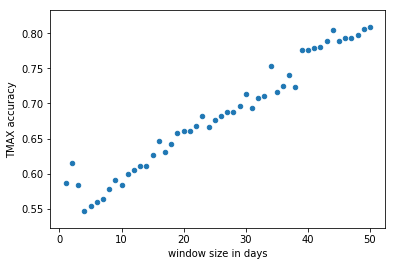

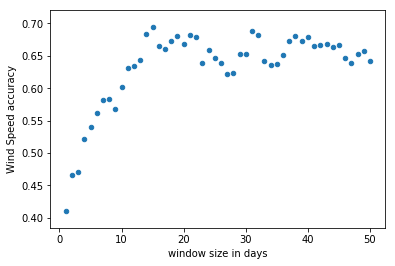

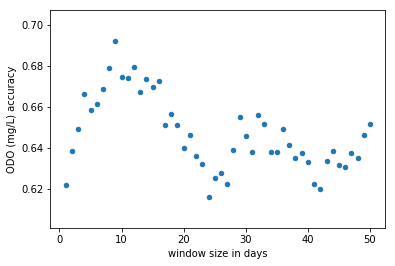

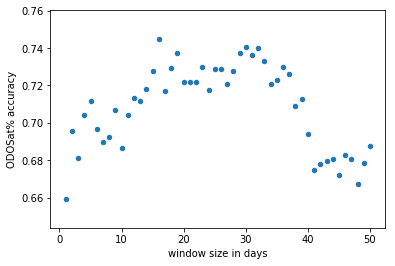

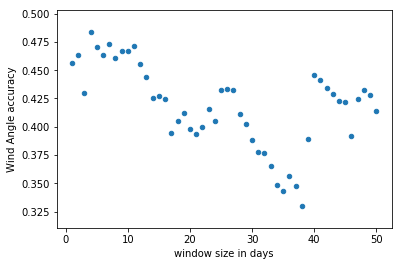

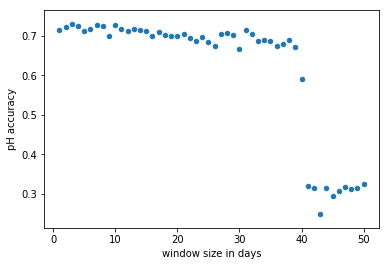

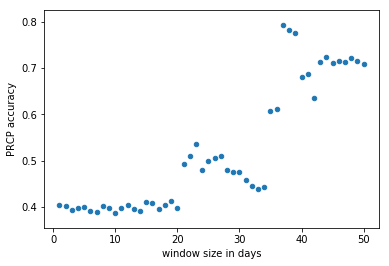

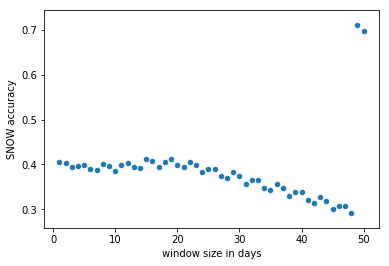

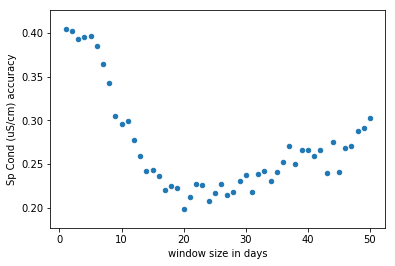

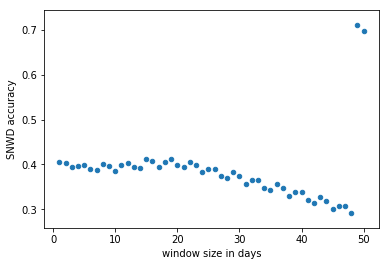

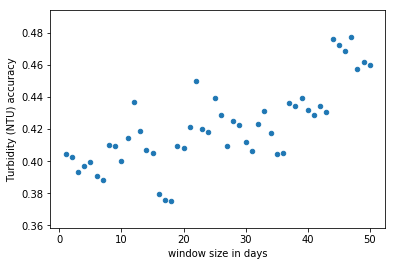

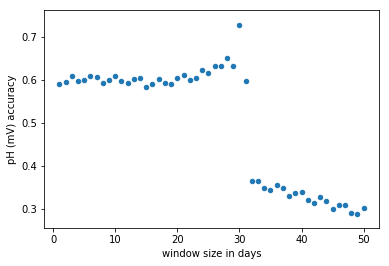

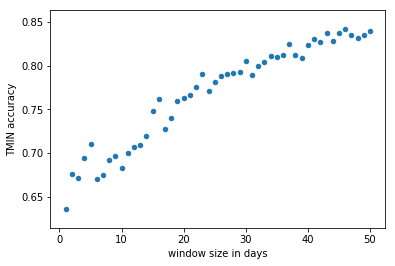

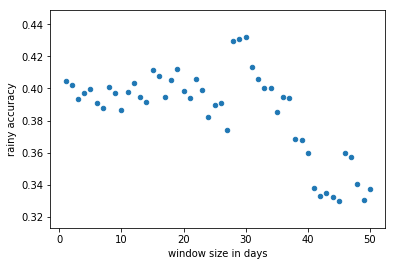

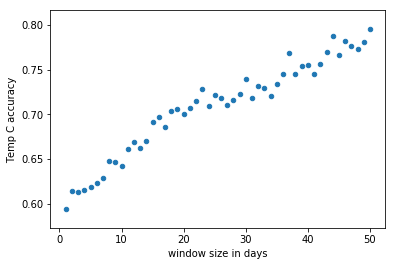

In [107]:
# Plot the accuracies vs window size for each column
sizes = [x.days for x in window_sizes]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "window size in days": sizes})
    df.plot(kind="scatter", y=col + " accuracy", x="window size in days")

## Greedy Custom Window Size
Create a greedy model using the best custom window sizes found above.

In [109]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, x_win in best_x_windows.items():
    print(col, x_win)
    parameters[col] = {'x_win_size':x_win}

# Windowize
print("Windowizing 2017 data sets")
train = hf.windowize(train_dfs[0], 'datetime', 
                     target_column, custom_parameters=parameters)
train = train.append(hf.windowize(train_dfs[1], 'datetime', 
                     target_column, custom_parameters=parameters))
print("Windowizing 2018 data sets")
test = hf.windowize(test_dfs[0], 'datetime', 
                    target_column, custom_parameters=parameters)
test = test.append(hf.windowize(test_dfs[1], 'datetime', 
                    target_column, custom_parameters=parameters))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()



TMAX 30 days 00:00:00
Wind Speed 15 days 00:00:00
ODO (mg/L) 9 days 00:00:00
ODOSat% 16 days 00:00:00
Wind Angle 4 days 00:00:00
pH 3 days 00:00:00
PRCP 23 days 00:00:00
SNOW 19 days 00:00:00
Sp Cond (uS/cm) 1 days 00:00:00
SNWD 19 days 00:00:00
Turbidity (NTU) 22 days 00:00:00
pH (mV) 30 days 00:00:00
TMIN 30 days 00:00:00
rainy 30 days 00:00:00
Temp C 30 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model with: TMAX
Accuracy 0.7135593220338983
Recall: 0.6802168021680217
Precision 0.8311258278145696
Confusion Matrix:
 [[170  51]
 [118 251]]

Training model with: TMIN
A

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37457627118644066
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [369   0]]

Training model with: pH
Accuracy 0.7542372881355932
Recall: 0.8997289972899729
Precision 0.7545454545454545
Confusion Matrix:
 [[113 108]
 [ 37 332]]

Training model with: Sp Cond (uS/cm)
Accuracy 0.33559322033898303
Recall: 0.01084010840108401
Precision 0.12903225806451613
Confusion Matrix:
 [[194  27]
 [365   4]]

Training model with: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37457627118644066
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [369   0]]

Training model with: pH (mV)
Accuracy 0.7305084745762712
Recall: 0.983739837398374
Precision 0.7034883720930233
Confusion Matrix:
 [[ 68 153]
 [  6 363]]

Training model with: Temp C
Accuracy 0.7389830508474576
Recall: 0.5989159891598916
Precision 0.973568281938326
Confusion Matrix:
 [[215   6]
 [148 221]]

Training model with: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37457627118644066
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [369   0]]

Training model with: PRCP
Accuracy 0.5220338983050847
Recall: 0.48509485094850946
Precision 0.6605166051660517
Confusion Matrix:
 [[129  92]
 [190 179]]

Training model with: Turbidity (NTU)
Accuracy 0.4576271186440678
Recall: 0.4634146341463415
Precision 0.5836177474402731
Confusion Matrix:
 [[ 99 122]
 [198 171]]

TMIN metric value: 0.8050847457627118
pH metric value: 0.7542372881355932
ODOSat% metric value: 0.7389830508474576
Temp C metric value: 0.7389830508474576
pH (mV) metric value: 0.7305084745762712
TMAX metric value: 0.7135593220338983
ODO (mg/L) metric value: 0.7033898305084746
Wind Speed metric value: 0.6661016949152543
PRCP metric value: 0.5220338983050847
Wind Angle metric value: 0.47796610169491527
Turbidity (NTU) metric value: 0.4576271186440678
rainy metric value: 0.37457627118644066
SNWD metric value: 0.37457627118644066
SNOW metric value: 0.37457627118644066
Sp Cond (uS/

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'pH (mV)', 'TMAX', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'pH', 'ODOSat%', 'Temp C', 'pH (mV)', 'TMAX', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8050847457627118
Test model recall: 0.8130081300813008
Test model precision: 0.8670520231213873

Updating greedy model

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7830508474576271
Test model recall: 0.926829268292683
Test model precision: 0.7720090293453724

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7372881355932204
Test model recall: 0.6233062330623306
Test model precision: 0.9349593495934959

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8135593220338984
Test model recall: 0.8319783197831978

In [111]:
print("Cross validate:")
base_columns = ['TMIN', 'Temp C', 'PRCP', 'Wind Angle', 'Sp Cond (uS/cm)']

print("test vs train:")
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom')
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

Cross validate:
test vs train:
accuracy 0.6757246376811594
recall 0.6812749003984063
precision 0.6333333333333333



Performance of the model and the columns it selects seems to be largely dependent on the buey location.

## Optimal Separation Size For Individual Features
Here we will use a constant window size of 7 days, but increase the x and y separation up to 43 days (7 + 43 = 50 day max window)

In [65]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
separations = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_sep = dict()

max_iter = 25000
loss = "log"

current_x_window = pd.Timedelta('7 days')
while current_x_window + current_separation <= max_x_window:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    separations.append(current_separation)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window + current_separation <= max_x_window_size_for_use:
                print("Updating best accuracy and shift size.")
                best_accuracies[col] = accuracy
                best_sep[col] = current_separation
        accuracies[col].append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.564179104477612
recall 0.40703517587939697
precision 0.7431192660550459

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6716417910447762
recall 0.5376884422110553
precision 0.856

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6029850746268657
recall 0.4321608040201005
precision 0.8113207547169812

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7970149253731343
recall 0.8391959798994975
precision 0.8226600985221675

Updating best accuracy and window size.
Training model on: ODOSat%
accuracy 0.8029850746268656
recall 0.7587939698492462
precision 0.893491124260355

Updating 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6835820895522388
recall 0.9396984924623115
precision 0.6654804270462633

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.39104477611940297
recall 0.010050251256281407
precision 0.2222222222222222

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5940298507462687
recall 1.0
precision 0.5940298507462687

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6179104477611941
recall 0.4120603015075377
precision 0.8817204301075269

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.44776119402985076
recall 0.11055276381909548
precision 0.7333333333333333

Updating best accuracy and window size.
current separation 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6276276276276276
recall 0.6030927835051546
precision 0.7134146341463414

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7417417417417418
recall 0.6958762886597938
precision 0.8333333333333334

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5765765765765766
recall 0.41237113402061853
precision 0.7476635514018691

Training model on: ODO (mg/L)
accuracy 0.792

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6726726726726727
recall 0.9381443298969072
precision 0.6523297491039427

Training model on: Sp Cond (uS/cm)
accuracy 0.37537537537537535
recall 0.02577319587628866
precision 0.20833333333333334

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5825825825825826
recall 1.0
precision 0.5825825825825826

Training model on: Temp C
accuracy 0.6396396396396397
recall 0.520618556701031
precision 0.7890625

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.46546546546546547
recall 0.28865979381443296
precision 0.5833333333333334

Updating best accuracy and window size.
current separation 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6525679758308157
recall 0.6256410256410256
precision 0.7439024390243902

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7613293051359517
recall 0.7128205128205128
precision 0.8580246913580247

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5921450151057401
recall 0.46153846153846156
precision 0.75

Training model on: ODO (mg/L)
accuracy 0.8126888217522659


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6646525679758308
recall 0.9333333333333333
precision 0.65

Training model on: Sp Cond (uS/cm)
accuracy 0.3202416918429003
recall 0.020512820512820513
precision 0.10526315789473684

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5891238670694864
recall 1.0
precision 0.5891238670694864

Training model on: Temp C
accuracy 0.6676737160120846
recall 0.558974358974359
precision 0.8195488721804511

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4622356495468278
recall 0.3282051282051282
precision 0.5765765765765766

current separation 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5818181818181818
recall 0.5151515151515151
precision 0.7083333333333334

Training model on: TMIN
accuracy 0.7
recall 0.5656565656565656
precision 0.896

Training model on: Wind Speed
accuracy 0.5666666666666667
recall 0.398989898989899
precision 0.7669902912621359

Training model on: ODO (mg/L)
accuracy 0.796969696969697
recall 0.8181818181818182
precision 0.8393782383419689

Training model on: ODOSat%
accuracy 0.806060606060606
recall 0.7373737373737373
precision 0.9240506329113924

Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6818181818181818
recall 0.9292929292929293
precision 0.6690909090909091

Training model on: Sp Cond (uS/cm)
accuracy 0.3090909090909091
recall 0.020202020202020204
precision 0.10526315789473684

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6
recall 1.0
precision 0.6

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6545454545454545
recall 0.45454545454545453
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46060606060606063
recall 0.29797979797979796
precision 0.6020408163265306

current separation 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6554878048780488
recall 0.6321243523316062
precision 0.7439024390243902

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7469512195121951
recall 0.7046632124352331
precision 0.8395061728395061

Training model on: Wind Speed
accuracy 0.5853658536585366
recall 0.45077720207253885
precision 0.7435897435897436

Training model on: ODO (mg/L)
accuracy 0.8201219512195121
recall 0.8549222797927462
precision 0.8418367346938775

Updating best accuracy and window size.
Training model on: ODOSat

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6676829268292683
recall 0.927461139896373
precision 0.6532846715328468

Training model on: Sp Cond (uS/cm)
accuracy 0.21951219512195122
recall 0.025906735751295335
precision 0.0684931506849315

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5884146341463414
recall 1.0
precision 0.5884146341463414

Training model on: Temp C
accuracy 0.649390243902439
recall 0.5077720207253886
precision 0.8305084745762712

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.5
recall 0.41450777202072536
precision 0.6106870229007634

Updating best accuracy and window size.
current separation 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6687116564417178
recall 0.6473684210526316
precision 0.75

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.754601226993865
recall 0.7157894736842105
precision 0.8395061728395061

Training model on: Wind Speed
accuracy 0.5736196319018405
recall 0.4421052631578947
precision 0.717948717948718

Training model on: ODO (mg/L)
accuracy 0.8128834355828221
recall 0.8421052631578947
precision 0.837696335078534

Training model on: ODOSat%
accuracy 0.865030

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6625766871165644
recall 0.9263157894736842
precision 0.6470588235294118

Training model on: Sp Cond (uS/cm)
accuracy 0.19325153374233128
recall 0.021052631578947368
precision 0.04938271604938271

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5828220858895705
recall 1.0
precision 0.5828220858895705

Training model on: Temp C
accuracy 0.6809815950920245
recall 0.5789473684210527
precision 0.8208955223880597

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4662576687116564
recall 0.39473684210526316
precision 0.5597014925373134

current separation 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6246153846153846
recall 0.5578947368421052
precision 0.7361111111111112

Training model on: TMIN
accuracy 0.7107692307692308
recall 0.5736842105263158
precision 0.8934426229508197

Training model on: Wind Speed
accuracy 0.5784615384615385
recall 0.4
precision 0.7676767676767676

Training model on: ODO (mg/L)
accuracy 0.7692307692307693
recall 0.7789473684210526
precision 0.8176795580110497

Training model on: ODOSat%
accuracy 0.8523076923076923
recall 0.7894736842105263
precision 0.94936708860759

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.68
recall 0.9315789473684211
precision 0.6604477611940298

Training model on: Sp Cond (uS/cm)
accuracy 0.26153846153846155
recall 0.021052631578947368
precision 0.06896551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5846153846153846
recall 1.0
precision 0.5846153846153846

Training model on: Temp C
accuracy 0.6707692307692308
recall 0.46842105263157896
precision 0.9368421052631579

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46153846153846156
recall 0.3473684210526316
precision 0.5641025641025641

current separation 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6253869969040248
recall 0.5595854922279793
precision 0.75

Training model on: TMIN
accuracy 0.7120743034055728
recall 0.5751295336787565
precision 0.9098360655737705

Training model on: Wind Speed
accuracy 0.5820433436532507
recall 0.43523316062176165
precision 0.7636363636363637

Training model on: ODO (mg/L)
accuracy 0.7523219814241486
recall 0.7512953367875648
precision 0.8192090395480226

Training model on: ODOSat%
accuracy 0.848297213622291
recall 0.7823834196891192
precision 0.9556962025316

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6594427244582043
recall 0.9015544041450777
precision 0.6566037735849056

Training model on: Sp Cond (uS/cm)
accuracy 0.24458204334365324
recall 0.025906735751295335
precision 0.08196721311475409

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5975232198142415
recall 1.0
precision 0.5975232198142415

Training model on: Temp C
accuracy 0.6687306501547987
recall 0.47150259067357514
precision 0.9479166666666666

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4613003095975232
recall 0.35233160621761656
precision 0.5811965811965812

current separation 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6915887850467289
recall 0.6756756756756757
precision 0.7621951219512195

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7383177570093458
recall 0.6108108108108108
precision 0.904

Training model on: Wind Speed
accuracy 0.6074766355140186
recall 0.4864864864864865
precision 0.743801652892562

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7258566978193146
recall 0.7513513513513513
precision 0.7679558011049724

Training model on: ODOSat%

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.5607476635514018
recall 0.5567567567567567
precision 0.6358024691358025

Updating best accuracy and window size.
Training model on: pH
accuracy 0.660436137071651
recall 0.9243243243243243
precision 0.6428571428571429

Training model on: Sp Cond (uS/cm)
accuracy 0.22741433021806853
recall 0.02702702702702703
precision 0.0684931506849315

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5763239875389408
recall 1.0
precision 0.5763239875389408

Training model on: Temp C
accuracy 0.6822429906542056
recall 0.5675675675675675
precision 0.8267716535433071

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP
accuracy 0.5607476635514018
recall 0.5567567567567567
precision 0.6358024691358025

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.470404984423676
recall 0.3945945945945946
precision 0.5572519083969466

current separation 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7115987460815048
recall 0.6935483870967742
precision 0.7865853658536586

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8244514106583072
recall 0.7849462365591398
precision 0.9012345679012346

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5768025078369

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.542319749216301
recall 0.5376344086021505
precision 0.625

Training model on: pH
accuracy 0.677115987460815
recall 0.9354838709677419
precision 0.6566037735849056

Training model on: Sp Cond (uS/cm)
accuracy 0.21316614420062696
recall 0.021505376344086023
precision 0.0547945205479452

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5830721003134797
recall 1.0
precision 0.5830721003134797

Training model on: Temp C
accuracy 0.7115987460815048
recall 0.6075268817204301
precision 0.8560606060606061

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5799373040752351
recall 0.6397849462365591
precision 0.6397849462365591

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.44200626959247646
recall 0.42473118279569894
precision 0.5266666666666666

current separation 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6415094339622641
recall 0.5789473684210527
precision 0.7638888888888888

Training model on: TMIN
accuracy 0.7264150943396226
recall 0.6
precision 0.912

Training model on: Wind Speed
accuracy 0.5754716981132075
recall 0.4263157894736842
precision 0.7570093457943925

Training model on: ODO (mg/L)
accuracy 0.6415094339622641
recall 0.4368421052631579


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5974842767295597
recall 1.0
precision 0.5974842767295597

Training model on: Temp C
accuracy 0.6761006289308176
recall 0.4789473684210526
precision 0.9578947368421052

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4308176100628931
recall 0.32105263157894737
precision 0.5398230088495575

current separation 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7215189873417721
recall 0.7043010752688172
precision 0.7987804878048781

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8227848101265823
recall 0.7849462365591398
precision 0.9012345679012346

Training model on: Wind Speed
accuracy 0.5664556962025317
recall 0.42473118279569894
precision 0.7247706422018348

Training model on: ODO (mg/L)
accuracy 0.5854430379746836
recall 0.3225806451612903
precision 0.9230769230769231

Training model on: ODOSat%
accuracy 0.810126582278

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5886075949367089
recall 1.0
precision 0.5886075949367089

Training model on: Temp C
accuracy 0.6962025316455697
recall 0.543010752688172
precision 0.9017857142857143

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4462025316455696
recall 0.3709677419354839
precision 0.5433070866141733

current separation 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7388535031847133
recall 0.7252747252747253
precision 0.8048780487804879

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8343949044585988
recall 0.8021978021978022
precision 0.9012345679012346

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5828025477707006
recall 0.43956043956043955
precision 0.7339449541284404

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.821656050955414
recall 0.7637362637362637
precision 0.9144736842105263

Training model on: Wind Angle
accuracy 0.4171974522292994
recall 0.17582417582417584
precision 0.49230769230769234

Training model on: rainy
accuracy 0.49363057324840764
recall 0.489010989010989
precision 0.5741935483870968

Training model on: pH
accuracy 0.6847133757961783
recall 0.9230769230769231
precision 0.6640316205533597

Training model on: Sp Cond (uS/cm)
accuracy 0.18789808917197454
recall 0.02197802197802198
precision 0.04938271604938271

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5796178343949044
recall 1.0
precision 0.5796178343949044

Training model on: Temp C
accuracy 0.7006369426751592
recall 0.6043956043956044
precision 0.8333333333333334

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46178343949044587
recall 0.3956043956043956
precision 0.549618320610687

current separation 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6837060702875399
recall 0.6216216216216216
precision 0.7986111111111112

Training model on: TMIN
accuracy 0.7699680511182109
recall 0.6432432432432432
precision 0.952

Training model on: Wind Speed
accuracy 0.5782747603833865
recall 0.372972972972973
precision 0.8117647058823529

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.6741214057507987
recall 0.4918918918918919
precision 0.9191919191919192

Training model on: Wind Angle
accuracy 0.41533546325878595
recall 0.1783783783783784
precision 0.515625

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7156549520766773
recall 0.9297297297297298
precision 0.6935483870967742

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.24920127795527156
recall 0.021621621621621623
precision 0.06896551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5910543130990416
recall 1.0
precision 0.5910543130990416

Training model on: Temp C
accuracy 0.6964856230031949
recall 0.4918918918918919
precision 0.9891304347826086

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4281150159744409
recall 0.2756756756756757
precision 0.53125

current separation 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6881028938906752
recall 0.6256684491978609
precision 0.8125

Training model on: TMIN
accuracy 0.7620578778135049
recall 0.6363636363636364
precision 0.952

Training model on: Wind Speed
accuracy 0.5337620578778135
recall 0.2887700534759358
precision 0.8181818181818182

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.5819935691318328
recall 0.3315508021390374
precision 0.9253731343283582

Training model on: Wind Angle
accuracy 0.4212218649517685
recall 0.19786096256684493
precision 0.5522388059701493

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7106109324758842
recall 0.8983957219251337
precision 0.702928870292887

Training model on: Sp Cond (uS/cm)
accuracy 0.24115755627009647
recall 0.026737967914438502
precision 0.0847457627118644

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6012861736334405
recall 1.0
precision 0.6012861736334405

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6816720257234726
recall 0.48128342245989303
precision 0.9782608695652174

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.40514469453376206
recall 0.19786096256684493
precision 0.5138888888888888

current separation 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7799352750809061
recall 0.7637362637362637
precision 0.8475609756097561

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8576051779935275
recall 0.8241758241758241
precision 0.9259259259259259

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5857605177993528
recall 0.3791208791208791
precision 0.8214285714285714

Training model on: ODO (mg/L)
accuracy 0.3818770226537217
recall 0.06043956043956044
precision 0.3548387096774194

Training 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7346278317152104
recall 0.9560439560439561
precision 0.7016129032258065

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.22653721682847897
recall 0.04945054945054945
precision 0.12

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5889967637540453
recall 1.0
precision 0.5889967637540453

Training model on: Temp C
accuracy 0.7119741100323624
recall 0.5769230769230769
precision 0.8974358974358975

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.47249190938511326
recall 0.3241758241758242
precision 0.5959595959595959

current separation 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8436482084690554
recall 0.842391304347826
precision 0.8908045977011494

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8566775244299675
recall 0.8206521739130435
precision 0.9320987654320988

Training model on: Wind Speed
accuracy 0.49185667752442996
recall 0.1956521739130435
precision 0.8181818181818182

Training model on: ODO (mg/L)
accuracy 0.36482084690553745
recall 0.11956521739130435
precision 0.4

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.48534201954397393
recall 0.375
precision 0.6160714285714286

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.755700325732899
recall 0.9728260869565217
precision 0.7188755020080321

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.22149837133550487
recall 0.04891304347826087
precision 0.1232876712328767

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5993485342019544
recall 1.0
precision 0.5993485342019544

Training model on: Temp C
accuracy 0.745928338762215
recall 0.657608695652174
precision 0.8897058823529411

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4234527687296417
recall 0.22826086956521738
precision 0.5454545454545454

current separation 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.738562091503268
recall 0.6702127659574468
precision 0.875

Training model on: TMIN
accuracy 0.7549019607843137
recall 0.6329787234042553
precision 0.952

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38235294117647056
recall 0.10106382978723404
precision 0.48717948717948717

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4019607843137255
recall 0.18085106382978725
precision 0.5396825396825397

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.8006535947712419
recall 0.8723404255319149
precision 0.8159203980099502

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.28431372549019607
recall 0.03723404255319149
precision 0.15555555555555556

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6143790849673203
recall 1.0
precision 0.6143790849673203

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6830065359477124
recall 0.48936170212765956
precision 0.989247311827957

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3790849673202614
recall 0.0
precision 0.0

current separation 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8223684210526315
recall 0.7989130434782609
precision 0.8963414634146342

Training model on: TMIN
accuracy 0.8223684210526315
recall 0.7934782608695652
precision 0.9012345679012346

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3684210526315789
recall 0.14673913043478262
precision 0.43548387096774194

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.40460526315789475
recall 0.1793478260869565
precision 0.5238095238095238

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7894736842105263
recall 0.9021739130434783
precision 0.7830188679245284

Training model on: Sp Cond (uS/cm)
accuracy 0.2138157894736842
recall 0.04891304347826087
precision 0.1232876712328767

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6052631578947368
recall 1.0
precision 0.6052631578947368

Training model on: Temp C
accuracy 0.7105263157894737
recall 0.5815217391304348
precision 0.9067796610169492

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.4868421052631579
recall 0.4945652173913043
precision 0.5909090909090909

Training model on: Turbidity (NTU)
accuracy 0.40460526315789475
recall 0.04891304347826087
precision 0.6

current separation 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8344370860927153
recall 0.8131868131868132
precision 0.9024390243902439

Training model on: TMIN
accuracy 0.8211920529801324
recall 0.7967032967032966
precision 0.8950617283950617

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3708609271523179
recall 0.18681318681318682
precision 0.4473684210526316

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.39403973509933776
recall 0.15384615384615385
precision 0.49122807017543857

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7980132450331126
recall 0.8846153846153846
precision 0.8009950248756219

Training model on: Sp Cond (uS/cm)
accuracy 0.18211920529801323
recall 0.04395604395604396
precision 0.09876543209876543

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6026490066225165
recall 1.0
precision 0.6026490066225165

Training model on: Temp C
accuracy 0.7615894039735099
recall 0.6758241758241759
precision 0.9044117647058824

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4470198675496689
recall 0.19230769230769232
precision 0.6363636363636364

current separation 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.770764119601329
recall 0.7027027027027027
precision 0.9027777777777778

Training model on: TMIN
accuracy 0.7375415282392026
recall 0.6162162162162163
precision 0.9344262295081968

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38205980066445183
recall 0.10270270270270271
precision 0.48717948717948717

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.37209302325581395
recall 0.11891891891891893
precision 0.4583333333333333

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.49169435215946844
recall 0.2
precision 0.8809523809523809

Training model on: Sp Cond (uS/cm)
accuracy 0.3023255813953488
recall 0.043243243243243246
precision 0.1951219512195122

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6146179401993356
recall 1.0
precision 0.6146179401993356

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6877076411960132
recall 0.4972972972972973
precision 0.989247311827957

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

current separation 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7558528428093646
recall 0.6898395721925134
precision 0.8958333333333334

Training model on: TMIN
accuracy 0.745819397993311
recall 0.6310160427807486
precision 0.944

Training model on: Wind Speed
accuracy 0.3411371237458194
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3612040133779264
recall 0.11764705882352941
precision 0.4583333333333333

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3712374581939799
recall 0.0962566844919786
precision 0.4864864864864865

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: pH


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.19732441471571907
recall 0.053475935828877004
precision 0.136986301369863

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6254180602006689
recall 1.0
precision 0.6254180602006689

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6989966555183946
recall 0.5240641711229946
precision 0.98989898989899

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

current separation 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8181818181818182
recall 0.8021978021978022
precision 0.8902439024390244

Training model on: TMIN
accuracy 0.7845117845117845
recall 0.7692307692307693
precision 0.8641975308641975

Training model on: Wind Speed
accuracy 0.3434343434343434
recall 0.03296703296703297
precision 0.24

Training model on: ODO (mg/L)
accuracy 0.3333333333333333
recall 0.15934065934065933
precision 0.3918918918918919

Training model on: ODOSat%
accuracy 0.3434343434343434
recall 0.038461538461538464
precision 0.25925925925925924

Training model on: Wind Angle
accuracy 0.37373737373737376
recall 0.0
precision 0.0

Training model on: rainy

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.16161616161616163
recall 0.07142857142857142
precision 0.13978494623655913

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6127946127946128
recall 1.0
precision 0.6127946127946128

Training model on: Temp C
accuracy 0.8013468013468014
recall 0.7142857142857143
precision 0.948905109489051

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

current separation 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7966101694915254
recall 0.8097826086956522
precision 0.8563218390804598

Training model on: TMIN
accuracy 0.7864406779661017
recall 0.8043478260869565
precision 0.8457142857142858

Training model on: Wind Speed
accuracy 0.3423728813559322
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3254237288135593
recall 0.19021739130434784
precision 0.4117647058823529

Training model on: ODOSat%
accuracy 0.29152542372881357
recall 0.07065217391304347
precision 0.2549019607843137

Training model on: Wind Angle
accuracy 0.41694915254237286
recall 0.13043478260869565
precision 0.6666666666666666

Training mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.21694915254237288
recall 0.18478260869565216
precision 0.2956521739130435

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6237288135593221
recall 1.0
precision 0.6237288135593221

Training model on: Temp C
accuracy 0.823728813559322
recall 0.7934782608695652
precision 0.9125

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5796610169491525
recall 0.75
precision 0.6388888888888888

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

current separation 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7619047619047619
recall 0.6968085106382979
precision 0.9097222222222222

Training model on: TMIN
accuracy 0.7755102040816326
recall 0.7553191489361702
precision 0.8765432098765432

Training model on: Wind Speed
accuracy 0.32653061224489793
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.30272108843537415
recall 0.10106382978723404
precision 0.34545454545454546

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.40816326530612246
recall 0.13297872340425532
precision 0.6944444444444444

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.3401360544217687
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.1870748299319728
recall 0.0797872340425532
precision 0.18518518518518517

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7210884353741497
recall 0.5904255319148937
precision 0.9568965517241379

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5918367346938775
recall 0.6595744680851063
precision 0.6888888888888889

Training model on: Turbidity (NTU)
accuracy 0.3877551020408163
recall 0.11170212765957446
precision 0.6176470588235294

current separation 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.773972602739726
recall 0.7934782608695652
precision 0.8390804597701149

Training model on: TMIN
accuracy 0.7876712328767124
recall 0.7989130434782609
precision 0.8546511627906976

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3356164383561644
recall 0.1793478260869565
precision 0.4342105263157895

Training model on: ODOSat%
accuracy 0.339041095890411
recall 0.05434782608695652
precision 0.3448275862068966

Training model on: Wind Angle
accuracy 0.4383561643835616
recall 0.3695652173913043
precision 0.5862068965517241

Training model on: rainy
accuracy 0.5068493150684932
recall 0.5271739130434783
precision 0.6298701298701299

Training model on: pH
accuracy 0.3253424657534247
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.1678082191780822
recall 0.09782608695652174
precision 0.18947368421052632

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7773972602739726
recall 0.7010869565217391
precision 0.9280575539568345

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5958904109589042
recall 0.7663043478260869
precision 0.6527777777777778

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

current separation 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7724137931034483
recall 0.7967032967032966
precision 0.8333333333333334

Training model on: TMIN
accuracy 0.7862068965517242
recall 0.7967032967032966
precision 0.8529411764705882

Training model on: Wind Speed
accuracy 0.4206896551724138
recall 0.07692307692307693
precision 1.0

Training model on: ODO (mg/L)
accuracy 0.32413793103448274
recall 0.18681318681318682
precision 0.4146341463414634

Training model on: ODOSat%
accuracy 0.32068965517241377
recall 0.08241758241758242
precision 0.3333333333333333

Training model on: Wind Angle
accuracy 0.49310344827586206
recall 0.46703296703296704
precision 0.629629629629

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7931034482758621
recall 0.7637362637362637
precision 0.8910256410256411

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6206896551724138
recall 0.7912087912087912
precision 0.6666666666666666

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

current separation 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7474048442906575
recall 0.6918918918918919
precision 0.8888888888888888

Training model on: TMIN
accuracy 0.754325259515571
recall 0.745945945945946
precision 0.8518518518518519

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.370242214532872
recall 0.1891891891891892
precision 0.5223880597014925

Training model on: ODOSat%
accuracy 0.32525951557093424
recall 0.043243243243243246
precision 0.3076923076923077

Training model on: Wind Angle
accuracy 0.43252595155709345
recall 0.3783783783783784
precision 0.5882352941176471

Training model on: rainy
accuracy 0.5397923875432526
recall 0.5567567567567567
precision 0.6688311688311688

Training model on: pH
accuracy 0.3079584775086505
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.17647058823529413
recall 0.10810810810810811
precision 0.21505376344086022

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7162629757785467
recall 0.5783783783783784
precision 0.963963963963964

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.643598615916955
recall 0.8054054054054054
precision 0.6898148148148148

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

current separation 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7804878048780488
recall 0.7700534759358288
precision 0.8780487804878049

Training model on: TMIN
accuracy 0.759581881533101
recall 0.7486631016042781
precision 0.8641975308641975

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3693379790940767
recall 0.20320855614973263
precision 0.5428571428571428

Training model on: ODOSat%
accuracy 0.30662020905923343
recall 0.058823529411764705
precision 0.3235294117647059

Training model on: Wind Angle
accuracy 0.43902439024390244
recall 0.42245989304812837
precision 0.5984848484848485

Training model on: rainy
accuracy 0.5400696864111498
recall 0.5561497326203209
precision 0.6797385620915033

Training model on: pH
accuracy 0.28222996515679444
recall 0.026737967914438502
precision 0.1724137931034483

Training model on: Sp Cond (uS/cm)
accuracy 0.16376306620209058
recall 0.10695187165775401
precision 0.21505376344086022

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7386759581881533
recall 0.6417112299465241
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6515679442508711
recall 0.8074866310160428
precision 0.7023255813953488

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

current separation 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7614035087719299
recall 0.7912087912087912
precision 0.8275862068965517

Training model on: TMIN
accuracy 0.7578947368421053
recall 0.7637362637362637
precision 0.8424242424242424

Training model on: Wind Speed
accuracy 0.45263157894736844
recall 0.18681318681318682
precision 0.8095238095238095

Training model on: ODO (mg/L)
accuracy 0.35789473684210527
recall 0.22527472527472528
precision 0.4939759036144578

Training model on: ODOSat%
accuracy 0.24912280701754386
recall 0.17032967032967034
precision 0.32978723404255317

Training model on: Wind Angle
accuracy 0.48771929824561405
recall 0.5384615384615384
precisi

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7543859649122807
recall 0.7362637362637363
precision 0.8589743589743589

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6596491228070176
recall 0.8186813186813187
precision 0.6995305164319249

Training model on: Turbidity (NTU)
accuracy 0.4
recall 0.3021978021978022
precision 0.5555555555555556

current separation 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7597173144876325
recall 0.8043478260869565
precision 0.8222222222222222

Training model on: TMIN
accuracy 0.7491166077738516
recall 0.75
precision 0.8466257668711656

Training model on: Wind Speed
accuracy 0.6749116607773852
recall 0.8913043478260869
precision 0.6949152542372882

Training model on: ODO (mg/L)
accuracy 0.35335689045936397
recall 0.266304347826087
precision 0.5051546391752577

Training mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3498233215547703
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7703180212014135
recall 0.8043478260869565
precision 0.8361581920903954

Training model on: SNOW
accuracy 0.6501766784452296
recall 1.0
precision 0.6501766784452296

Training model on: PRCP
accuracy 0.6925795053003534
recall 0.8586956521739131
precision 0.7214611872146118

Training model on: Turbidity (NTU)
accuracy 0.5053003533568905
recall 0.625
precision 0.6182795698924731

current separation 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7730496453900709
recall 0.7659574468085106
precision 0.8780487804878049

Training model on: TMIN
accuracy 0.7588652482269503
recall 0.75
precision 0.8703703703703703

Training model on: Wind Speed
accura

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6985815602836879
recall 0.6276595744680851
precision 0.8872180451127819

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6808510638297872
recall 0.8191489361702128
precision 0.7333333333333333

Training model on: Turbidity (NTU)
accuracy 0.3900709219858156
recall 0.34574468085106386
precision 0.5701754385964912

current separation 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7714285714285715
recall 0.7989130434782609
precision 0.8448275862068966

Training model on: TMIN
accuracy 0.7535714285714286
recall 0.7554347826086957
precision 0.852760736196319

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38571428571428573
recall 0.2554347826086957
precision 0.573170731707317

Training model on: ODOSat%
accuracy 0.2785714285714286
recall 0.19021739130434784
precision 0.3977272727272727

Training model on: Wind Angle
accuracy 0.5178571428571429
recall 0.5543478260869565
precision 0.6580645161290323

Training model on: rainy
accuracy 0.5714285714285714
recall 0.5706521739130435
precision 0.7191780821917808

Training model on: pH
accuracy 0.26071428571428573
recall 0.02717391304347826
precision 0.15151515151515152

Training model on: Sp Cond (uS/cm)
accuracy 0.2892857142857143
recall 0.29347826086956524
precision 0.43902439024390244

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7035714285714286
recall 0.6521739130434783
precision 0.8633093525179856

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6857142857142857
recall 0.8260869565217391
precision 0.7307692307692307

Training model on: Turbidity (NTU)
accuracy 0.4392857142857143
recall 0.44021739130434784
precision 0.6

current separation 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7769784172661871
recall 0.8241758241758241
precision 0.8333333333333334

Training model on: TMIN
accuracy 0.7589928057553957
recall 0.7637362637362637
precision 0.852760736196319

Training model on: Wind Speed
accuracy 0.4136690647482014
recall 0.31868131868131866
precision 0.5979381443298969

Training model on: ODO (mg/L)
accuracy 0.35611510791366907
recall 0.2692307692307692
precision 0.51578947368421

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7482014388489209
recall 0.7472527472527473
precision 0.85

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7122302158273381
recall 0.8681318681318682
precision 0.7383177570093458

Training model on: Turbidity (NTU)
accuracy 0.5143884892086331
recall 0.6043956043956044
precision 0.6358381502890174

current separation 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7436823104693141
recall 0.6972972972972973
precision 0.8958333333333334

Training model on: TMIN
accuracy 0.7653429602888087
recall 0.7621621621621621
precision 0.8703703703703703

Training model on: Wind Speed
accuracy 0.2743682310469314
recall 0.010810810810810811
precision 0.1

Training model on: ODO (mg/L)
accuracy 0.4043321299638989
recall 0.2594594594594595
precision 0.63157894736842

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6859205776173285
recall 0.5675675675675675
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6823104693140795
recall 0.8162162162162162
precision 0.7365853658536585

Training model on: Turbidity (NTU)
accuracy 0.36101083032490977
recall 0.05945945945945946
precision 0.7857142857142857

current separation 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8072727272727273
recall 0.7967914438502673
precision 0.9085365853658537

Training model on: TMIN
accuracy 0.7636363636363637
recall 0.7593582887700535
precision 0.8765432098765432

Training model on: Wind Speed
accuracy 0.2909090909090909
recall 0.0053475935828877
precision 0.1

Training model on: ODO (mg/L)
accuracy 0.41454545454545455
recall 0.27807486631016043
precision 0.666666666666

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7054545454545454
recall 0.5989304812834224
precision 0.9491525423728814

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6872727272727273
recall 0.8128342245989305
precision 0.7487684729064039

Training model on: Turbidity (NTU)
accuracy 0.3890909090909091
recall 0.3155080213903743
precision 0.5959595959595959

current separation 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8241758241758241
recall 0.8626373626373627
precision 0.8722222222222222

Training model on: TMIN
accuracy 0.7619047619047619
recall 0.7692307692307693
precision 0.8588957055214724

Training model on: Wind Speed
accuracy 0.6190476190476191
recall 0.7967032967032966
precision 0.6839622641509434

Training model on: ODO (mg/L)
accuracy 0.39194139194139194
recall 0.3131868131868132
precision 0.581632653061224

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7509157509157509
recall 0.7582417582417582
precision 0.8518518518518519

Training model on: SNOW
accuracy 0.6666666666666666
recall 1.0
precision 0.6666666666666666

Training model on: PRCP
accuracy 0.6813186813186813
recall 0.8351648351648352
precision 0.7272727272727273

Training model on: Turbidity (NTU)
accuracy 0.5457875457875457
recall 0.6373626373626373
precision 0.6666666666666666

current separation 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8339483394833949
recall 0.9402173913043478
precision 0.8357487922705314

Training model on: TMIN
accuracy 0.7675276752767528
recall 0.782608695652174
precision 0.8622754491017964

Training m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3210332103321033
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7896678966789668
recall 0.8586956521739131
precision 0.8359788359788359

Training model on: SNOW
accuracy 0.6789667896678967
recall 1.0
precision 0.6789667896678967

Training model on: PRCP
accuracy 0.6863468634686347
recall 0.8369565217391305
precision 0.7368421052631579

Training model on: Turbidity (NTU)
accuracy 0.6678966789667896
recall 0.8206521739130435
precision 0.7259615384615384

current separation 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8222222222222222
recall 0.8085106382978723
precision 0.926829268292683

Training model on: TMIN
accuracy 0.762962962962963
recall 0.7553191489361702
precision 0.8875

Training model on: Wind

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.45185185185185184
recall 0.324468085106383
precision 0.7439024390243902

Training model on: ODOSat%
accuracy 0.34074074074074073
recall 0.2978723404255319
precision 0.5490196078431373

Training model on: Wind Angle
accuracy 0.5296296296296297
recall 0.5478723404255319
precision 0.7103448275862069

Training model on: rainy
accuracy 0.5185185185185185
recall 0.5159574468085106
precision 0.7132352941176471

Training model on: pH
accuracy 0.22592592592592592
recall 0.03723404255319149
precision 0.2

Training model on: Sp Cond (uS/cm)
accuracy 0.3037037037037037
recall 0.31382978723404253
precision 0.5

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7037037037037037
recall 0.6382978723404256
precision 0.9090909090909091

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.674074074074074
recall 0.7925531914893617
precision 0.7525252525252525

Training model on: Turbidity (NTU)
accuracy 0.42592592592592593
recall 0.3882978723404255
precision 0.6460176991150443

current separation 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7947761194029851
recall 0.8586956521739131
precision 0.8449197860962567

Training model on: TMIN
accuracy 0.7313432835820896
recall 0.7336956521739131
precision 0.8544303797468354

Training model on: Wind Speed
accuracy 0.6865671641791045
recall 0.9728260869565217
precision 0.6937984496124031

Training model on: ODO (mg/L)
accuracy 0.4253731343283582
recall 0.34782608695652173
precision 0.6

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31343283582089554
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7910447761194029
recall 0.8315217391304348
precision 0.8595505617977528

Training model on: SNOW
accuracy 0.6865671641791045
recall 1.0
precision 0.6865671641791045

Training model on: PRCP
accuracy 0.6865671641791045
recall 0.8315217391304348
precision 0.7427184466019418

Training model on: Turbidity (NTU)
accuracy 0.5597014925373134
recall 0.6413043478260869
precision 0.6941176470588235

current separation 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8195488721804511
recall 0.9230769230769231
precision 0.8316831683168316

Training model on: TMIN
accuracy 0.7593984962406015
recall 0.8186813186813187
precision 0.8277777777777777

Training

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3157894736842105
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7669172932330827
recall 0.8296703296703297
precision 0.8296703296703297

Training model on: SNOW
accuracy 0.6842105263157895
recall 1.0
precision 0.6842105263157895

Training model on: PRCP
accuracy 0.6842105263157895
recall 0.8351648351648352
precision 0.7378640776699029

Training model on: Turbidity (NTU)
accuracy 0.631578947368421
recall 0.7252747252747253
precision 0.7333333333333333

current separation 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7962264150943397
recall 0.7989130434782609
precision 0.8963414634146342

Training model on: TMIN
accuracy 0.7094339622641509
recall 0.7119565217391305
precision 0.8451612903225807

Training m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7358490566037735
recall 0.6793478260869565
precision 0.9191176470588235

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7018867924528301
recall 0.8315217391304348
precision 0.7611940298507462

Training model on: Turbidity (NTU)
accuracy 0.5849056603773585
recall 0.625
precision 0.7371794871794872

current separation 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7908745247148289
recall 0.842391304347826
precision 0.856353591160221

Training model on: TMIN
accuracy 0.7680608365019012
recall 0.8586956521739131
precision 0.8186528497409327

Training model on: Wind Speed
accuracy 0.5741444866920152
recall 0.717391304347826
precision 0.6875

Training model on: ODO (mg/L)
accuracy 0.4524714828897338
recall 0.3695652173913043
precision 0.7083333333333334

Training mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30038022813688214
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.8060836501901141
recall 0.8315217391304348
precision 0.884393063583815

Training model on: SNOW
accuracy 0.6996197718631179
recall 1.0
precision 0.6996197718631179

Training model on: PRCP
accuracy 0.7224334600760456
recall 0.8478260869565217
precision 0.7761194029850746

Training model on: Turbidity (NTU)
accuracy 0.6159695817490495
recall 0.6684782608695652
precision 0.754601226993865

current separation 43 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: TMIN
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: Wind Speed
accuracy 0.708

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31417624521072796
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.789272030651341
recall 0.9385474860335196
precision 0.7924528301886793

Training model on: SNOW
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: PRCP
accuracy 0.7318007662835249
recall 1.0
precision 0.7188755020080321

Training model on: Turbidity (NTU)
accuracy 0.6973180076628352
recall 0.7988826815642458
precision 0.7688172043010753



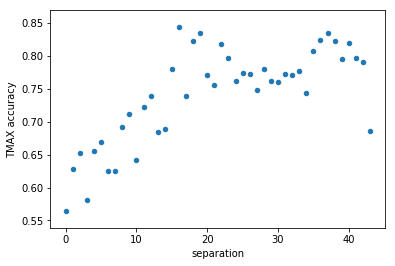

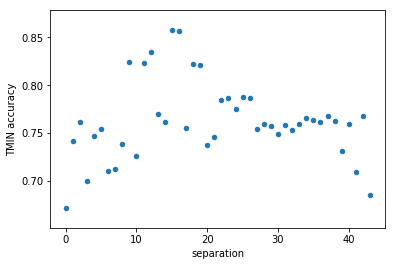

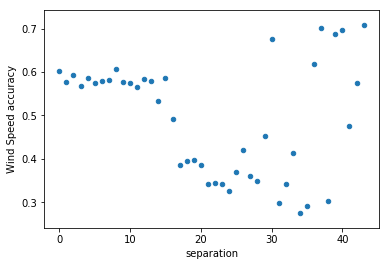

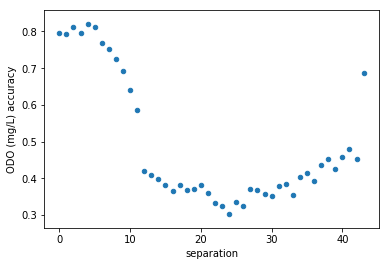

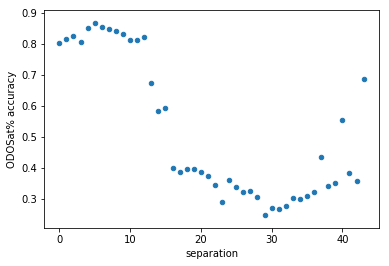

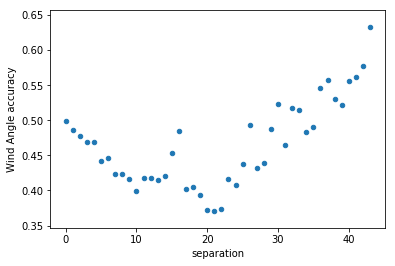

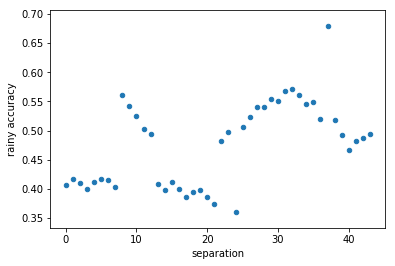

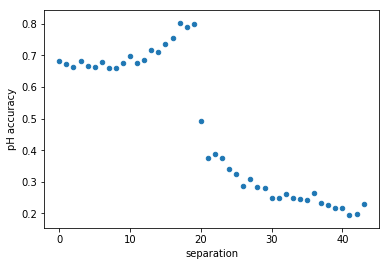

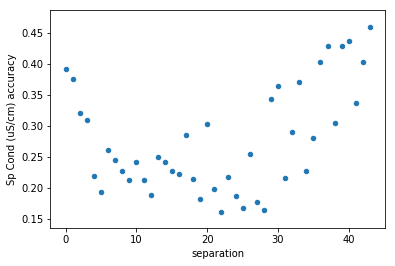

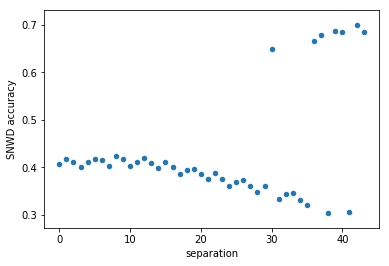

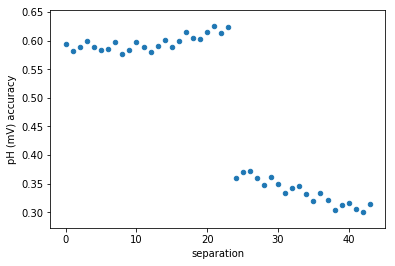

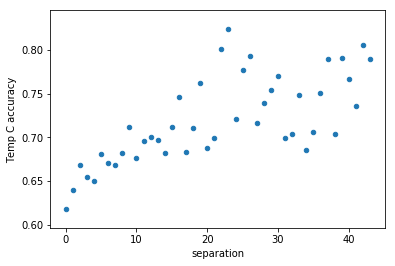

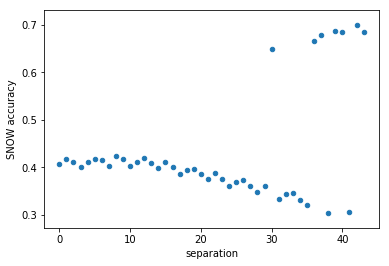

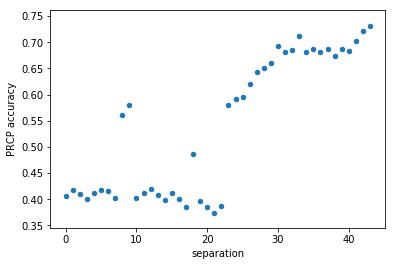

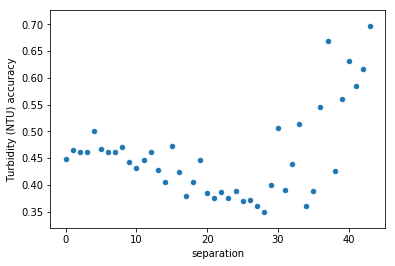

In [67]:
# Plot the accuracies vs window size for each column
seps = [x.days for x in separations]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "separation": seps})
    df.plot(kind="scatter", y=col + " accuracy", x="separation")

## Greedy Custom Separation Size
Create a greedy model using the best custom separation sizes found above.

In [70]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, sep in best_sep.items():
    print(col, sep)
    parameters[col] = {'separation':sep, 'x_win_size':pd.Timedelta('7 days')}

# Windowize
print("Windowizing 2017 data set:", train_index)
train = hf.windowize(train_dfs[train_index], 'datetime', 
                     target_column, custom_parameters=parameters)
print("Windowizing 2018 data set:", test_index)
test = hf.windowize(test_dfs[test_index], 'datetime', 
                    target_column, custom_parameters=parameters)
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

TMAX 16 days 00:00:00
TMIN 15 days 00:00:00
Wind Speed 8 days 00:00:00
ODO (mg/L) 4 days 00:00:00
ODOSat% 5 days 00:00:00
Wind Angle 0 days 00:00:00
rainy 8 days 00:00:00
pH 17 days 00:00:00
Sp Cond (uS/cm) 0 days 00:00:00
SNWD 8 days 00:00:00
pH (mV) 21 days 00:00:00
Temp C 23 days 00:00:00
SNOW 8 days 00:00:00
PRCP 9 days 00:00:00
Turbidity (NTU) 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model with: TMAX
Accuracy 0.8169491525423729
Recall: 0.842391304347826
Precision 0.8611111111111112
Confusion Matrix:
 [[ 86  25]
 [ 29 155]]

Training model with: TMIN
Accuracy 0.8305084745762712
Recall: 0.842391304347826
Precision 0.8806818181818182
Confusion Matrix:
 [[ 90  21]
 [ 29 155]]

Training model with: Wind Speed
Accuracy 0.5457627118644067
Recall: 0.5163

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.376271186440678
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[111   0]
 [184   0]]

Training model with: pH (mV)
Accuracy 0.6237288135593221
Recall: 1.0
Precision 0.6237288135593221
Confusion Matrix:
 [[  0 111]
 [  0 184]]

Training model with: Temp C
Accuracy 0.823728813559322
Recall: 0.7880434782608695
Precision 0.9177215189873418
Confusion Matrix:
 [[ 98  13]
 [ 39 145]]

Training model with: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.376271186440678
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[111   0]
 [184   0]]

Training model with: PRCP
Accuracy 0.6305084745762712
Recall: 0.7608695652173914
Precision 0.6829268292682927
Confusion Matrix:
 [[ 46  65]
 [ 44 140]]

Training model with: Turbidity (NTU)
Accuracy 0.5084745762711864
Recall: 0.6467391304347826
Precision 0.5979899497487438
Confusion Matrix:
 [[ 31  80]
 [ 65 119]]

ODOSat% metric value: 0.8779661016949153
ODO (mg/L) metric value: 0.8745762711864407
TMIN metric value: 0.8305084745762712
Temp C metric value: 0.823728813559322
TMAX metric value: 0.8169491525423729
pH metric value: 0.7491525423728813
PRCP metric value: 0.6305084745762712
pH (mV) metric value: 0.6237288135593221
rainy metric value: 0.5627118644067797
Wind Speed metric value: 0.5457627118644067
Turbidity (NTU) metric value: 0.5084745762711864
Wind Angle metric value: 0.47796610169491527
SNWD metric value: 0.376271186440678
SNOW metric value: 0.376271186440678
Sp Cond (uS/cm) metri

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'pH', 'PRCP', 'pH (mV)', 'rainy', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'pH', 'PRCP', 'pH (mV)', 'rainy', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8779661016949153
Test model recall: 0.8586956521739131
Test model precision: 0.9404761904761905

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8745762711864407
Test model recall: 0.8586956521739131
Test model precision: 0.9349112426035503

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.864406779661017
Test model recall: 0.8532608695652174
Test model precision: 0.9235294117647059

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8779661016949153
Test model recall: 0

## Greedy Window Size
Find a single optimal window size for all features

In [98]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(30, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window

window_sizes = []
accuracies = []

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:

    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data sets")
    train = hf.data_window_reduction(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    train = train.append(hf.data_window_reduction(
        train_dfs[1], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window))
    print("Windowizing 2018 data sets")
    test = hf.data_window_reduction(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    test = test.append(hf.data_window_reduction(
        test_dfs[1], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns )
    accuracies.append(accuracy)
    window_sizes.append(current_x_window)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
        best_x_window = current_x_window
        best_y_window = current_y_window
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Angle', 'Wind Speed', 'rainy', 'Sp Cond (uS/cm)', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Angle', 'Wind Speed', 'rainy', 'Sp Cond (uS/cm)', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7144927536231884
Test model recall: 0.805352798053528
Test model precision: 0.7388392857142857

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7275362318840579
Test model recall: 0.7761557177615572
Test model precision: 0.7686746987951807

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7420289855072464
Test model recall: 0.7956204379562044
Test model precision: 0.7767220902612827

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)']
Tes

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Temp C', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'rainy', 'Sp Cond (uS/cm)', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Temp C', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'rainy', 'Sp Cond (uS/cm)', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7215743440233237
Test model recall: 0.8146341463414634
Test model precision: 0.7438752783964365

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.749271137026239
Test model recall: 0.7951219512195122
Test model precision: 0.7874396135265701

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.749271137026239
Test model recall: 0.7926829268292683
Test model precision: 0.7888349514563107

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.746355685131

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'rainy', 'Sp Cond (uS/cm)', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'rainy', 'Sp Cond (uS/cm)', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.72953216374269
Test model recall: 0.8192771084337349
Test model precision: 0.7555555555555555

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7733918128654971
Test model recall: 0.7734939759036145
Test model precision: 0.8403141361256544

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7616959064327485
Test model recall: 0.7710843373493976
Test model precision: 0.8247422680412371

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.769005847953

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7264705882352941
Test model recall: 0.8219512195121951
Test model precision: 0.7488888888888889

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7617647058823529
Test model recall: 0.7536585365853659
Test model precision: 0.8351351351351352

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7617647058823529
Test model recall: 0.7658536585365854
Test model precision: 0.8263157894736842

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7602941176

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7130177514792899
Test model recall: 0.8103448275862069
Test model precision: 0.7376681614349776

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7662721893491125
Test model recall: 0.7389162561576355
Test model precision: 0.8522727272727273

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7618343195266272
Test model recall: 0.7315270935960592
Test model precision: 0.8510028653295129

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7692307692

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7176820208023774
Test model recall: 0.8195121951219512
Test model precision: 0.7433628318584071

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7711738484398217
Test model recall: 0.7317073170731707
Test model precision: 0.872093023255814

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7711738484398217
Test model recall: 0.7341463414634146
Test model precision: 0.869942196531792

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.772659732540

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7283582089552239
Test model recall: 0.8170731707317073
Test model precision: 0.7579185520361991

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7686567164179104
Test model recall: 0.7073170731707317
Test model precision: 0.8923076923076924

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7776119402985074
Test model recall: 0.7268292682926829
Test model precision: 0.8895522388059701

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)']
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7252252252252253
Test model recall: 0.8220551378446115
Test model precision: 0.7454545454545455

Updating greedy model

Training model with: ['pH', 'TMIN']
Test model accuracy: 0.7582582582582582
Test model recall: 0.8471177944862155
Test model precision: 0.771689497716895

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%']
Test model accuracy: 0.7792792792792793
Test model recall: 0.731829573934837
Test model precision: 0.8795180722891566

Updating greedy model

Training model with: ['pH', 'TMIN', 'ODOSat%', 'ODO (mg/L)']
Test mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.7069486404833837
Test model recall: 0.556390977443609
Test model precision: 0.9288702928870293

Updating greedy model

Training model with: ['ODOSat%', 'pH']
Test model accuracy: 0.7794561933534743
Test model recall: 0.7268170426065163
Test model precision: 0.8868501529051988

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN']
Test model accuracy: 0.783987915407855
Test model recall: 0.7343358395989975
Test model precision: 0.8878787878787879

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)']

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7272727272727273
Test model recall: 0.8320987654320988
Test model precision: 0.7505567928730512

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.75
Test model recall: 0.6765432098765433
Test model precision: 0.8896103896103896

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7515151515151515
Test model recall: 0.6790123456790124
Test model precision: 0.889967637540453

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accura

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7164634146341463
Test model recall: 0.8405063291139241
Test model precision: 0.7296703296703296

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7545731707317073
Test model recall: 0.6936708860759494
Test model precision: 0.8726114649681529

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7545731707317073
Test model recall: 0.6936708860759494
Test model precision: 0.8726114649681529

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7789634146

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.7131901840490797
Test model recall: 0.5681233933161953
Test model precision: 0.9208333333333333

Updating greedy model

Training model with: ['ODOSat%', 'pH']
Test model accuracy: 0.7776073619631901
Test model recall: 0.6786632390745502
Test model precision: 0.9295774647887324

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN']
Test model accuracy: 0.7791411042944786
Test model recall: 0.6812339331619537
Test model precision: 0.9298245614035088

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7164869029275809
Test model recall: 0.8371501272264631
Test model precision: 0.732739420935412

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7889060092449923
Test model recall: 0.6972010178117048
Test model precision: 0.9383561643835616

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7889060092449923
Test model recall: 0.6972010178117048
Test model precision: 0.9383561643835616

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.78120184899

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7198142414860681
Test model recall: 0.6412213740458015
Test model precision: 0.863013698630137

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.718266253869969
Test model recall: 0.5776081424936387
Test model precision: 0.934156378600823

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.7956656346749226
Test model recall: 0.8880407124681934
Test model precision: 0.7986270022883295

Updating greedy model

Training model with: ['TMIN', 'pH', 'Wind Speed']
Test model accuracy: 0.7848297213622291
Test m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Wind Speed', 'Temp C', 'ODO (mg/L)', 'TMAX', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Wind Speed', 'Temp C', 'ODO (mg/L)', 'TMAX', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7476635514018691
Test model recall: 0.6798941798941799
Test model precision: 0.8624161073825504

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7274143302180686
Test model recall: 0.5873015873015873
Test model precision: 0.921161825726141

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8037383177570093
Test model recall: 0.9047619047619048
Test model precision: 0.7916666666666666

Updating greedy model

Training model with: ['TMIN', 'pH', 'Wind Speed']
Test model accuracy: 0.7928348909657321
Test

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Temp C', 'ODO (mg/L)', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Temp C', 'ODO (mg/L)', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7617554858934169
Test model recall: 0.701058201058201
Test model precision: 0.8717105263157895

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7429467084639498
Test model recall: 0.5952380952380952
Test model precision: 0.9533898305084746

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.799373040752351
Test model recall: 0.9153439153439153
Test model precision: 0.7828054298642534

Updating greedy model

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.8072100313479624
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Temp C', 'Wind Speed', 'ODO (mg/L)', 'TMAX', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Temp C', 'Wind Speed', 'ODO (mg/L)', 'TMAX', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7279874213836478
Test model recall: 0.6545454545454545
Test model precision: 0.863013698630137

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7169811320754716
Test model recall: 0.5584415584415584
Test model precision: 0.9555555555555556

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8270440251572327
Test model recall: 0.9298701298701298
Test model precision: 0.8117913832199547

Updating greedy model

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.8160377358490566
Test mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'TMAX', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'TMAX', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.740506329113924
Test model recall: 0.675531914893617
Test model precision: 0.8581081081081081

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7294303797468354
Test model recall: 0.574468085106383
Test model precision: 0.9515418502202643

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7674050632911392
Test model recall: 0.723404255319149
Test model precision: 0.8634920634920635

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.8006329113924051
Test mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7595541401273885
Test model recall: 0.7073170731707317
Test model precision: 0.8585526315789473

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7404458598726115
Test model recall: 0.5907859078590786
Test model precision: 0.9478260869565217

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.785031847133758
Test model recall: 0.7560975609756098
Test model precision: 0.8611111111111112

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.8089171974522293
Test

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Temp C', 'Wind Speed', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'pH', 'Temp C', 'Wind Speed', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7632
Test model recall: 0.723404255319149
Test model precision: 0.8607594936708861

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7344
Test model recall: 0.5877659574468085
Test model precision: 0.9525862068965517

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8192
Test model recall: 0.9175531914893617
Test model precision: 0.8079625292740047

Updating greedy model

Training model with: ['TMIN', 'pH', 'Temp C']
Test model accuracy: 0.8096
Test model recall: 0.9601063829787234
Test model precisi

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7668810289389068
Test model recall: 0.7294429708222812
Test model precision: 0.8647798742138365

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7395498392282959
Test model recall: 0.596816976127321
Test model precision: 0.9574468085106383

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8054662379421221
Test model recall: 0.8090185676392573
Test model precision: 0.8615819209039548

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.8102893890675241
Test

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7750809061488673
Test model recall: 0.7493188010899182
Test model precision: 0.8540372670807453

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7411003236245954
Test model recall: 0.5994550408719346
Test model precision: 0.944206008583691

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7831715210355987
Test model recall: 0.784741144414169
Test model precision: 0.8396501457725948

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.7977346278317152
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7899022801302932
Test model recall: 0.7669376693766937
Test model precision: 0.8680981595092024

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.742671009771987
Test model recall: 0.6016260162601627
Test model precision: 0.9527896995708155

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8143322475570033
Test model recall: 0.8346883468834688
Test model precision: 0.853185595567867

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.8013029315960912
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7712418300653595
Test model recall: 0.7486772486772487
Test model precision: 0.8628048780487805

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.738562091503268
Test model recall: 0.6005291005291006
Test model precision: 0.961864406779661

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7712418300653595
Test model recall: 0.7486772486772487
Test model precision: 0.8628048780487805

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.826797385620915
Test model recall: 0.9206349206349206
T

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'ODO (mg/L)', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.78125
Test model recall: 0.7681940700808625
Test model precision: 0.858433734939759

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.75
Test model recall: 0.6199460916442049
Test model precision: 0.9543568464730291

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7763157894736842
Test model recall: 0.7870619946091644
Test model precision: 0.836676217765043

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.819078947368421
Test model recall: 0.921832884097035
Test model precision: 0.808

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'ODO (mg/L)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7880794701986755
Test model recall: 0.779891304347826
Test model precision: 0.8592814371257484

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7549668874172185
Test model recall: 0.6304347826086957
Test model precision: 0.9508196721311475

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7913907284768212
Test model recall: 0.7934782608695652
Test model precision: 0.8538011695906432

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'TMAX']
Test model accuracy: 0.7913907284768212
Te

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'Wind Speed', 'ODO (mg/L)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7903494176372712
Test model recall: 0.7792553191489362
Test model precision: 0.8720238095238095

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7454242928452579
Test model recall: 0.6223404255319149
Test model precision: 0.9551020408163265

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7903494176372712
Test model recall: 0.7792553191489362
Test model precision: 0.8720238095238095

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8153078202995009
Test model recall: 0.909574468085106

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'ODO (mg/L)', 'Wind Speed', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7525083612040134
Test model recall: 0.6339522546419099
Test model precision: 0.9598393574297188

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7909698996655519
Test model recall: 0.7851458885941645
Test model precision: 0.8705882352941177

Training model with: ['TMIN', 'pH']
Test model accuracy: 0.8478260869565217
Test model recall: 0.907161803713527

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH', 'TMAX', 'ODO (mg/L)', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.7929292929292929
Test model recall: 0.7983651226158038
Test model precision: 0.8567251461988304

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.7710437710437711
Test model recall: 0.6648501362397821
Test model precision: 0.9494163424124513

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.7996632996632996
Test model recall: 0.8092643051771117
Test model precision: 0.8583815028901735

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH']
Test model accuracy: 0.8148148148148148
Tes

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH (mV)', 'TMAX', 'pH', 'Wind Speed', 'ODO (mg/L)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['TMIN', 'ODOSat%', 'Temp C', 'pH (mV)', 'TMAX', 'pH', 'Wind Speed', 'ODO (mg/L)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['TMIN']
Test model accuracy: 0.8050847457627118
Test model recall: 0.8130081300813008
Test model precision: 0.8670520231213873

Updating greedy model

Training model with: ['TMIN', 'ODOSat%']
Test model accuracy: 0.764406779661017
Test model recall: 0.6558265582655827
Test model precision: 0.952755905511811

Training model with: ['TMIN', 'Temp C']
Test model accuracy: 0.8135593220338984
Test model recall: 0.8319783197831978
Test model precision: 0.8647887323943662

Updating greedy model

Training model with: ['TMIN', 'Temp C', 'pH (mV)']
Test model accuracy: 0.7237288135593221


In [99]:
print("best accuracy", best_accuracy)
print("best recall", best_recall)
print("best precision", best_precision)
print("best x window", best_x_window)

best accuracy 0.8545150501672241
best recall 0.9045092838196287
best precision 0.8698979591836735
best x window 28 days 00:00:00


In [104]:
# Cross validate
base_columns = ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)']
# Windowize
print("current x window", best_x_window)
print("Windowizing 2017 data sets")
train = hf.data_window_reduction(
    train_dfs[0], 'datetime', target_column, 
    x_win_size=best_x_window)
train = train.append(hf.data_window_reduction(
    train_dfs[1], 'datetime', target_column, 
    x_win_size=best_x_window))
print("Windowizing 2018 data sets")
test = hf.data_window_reduction(
    test_dfs[0], 'datetime', target_column,
    x_win_size=best_x_window)
test = test.append(hf.data_window_reduction(
    test_dfs[1], 'datetime', target_column,
    x_win_size=best_x_window))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom' )
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)

current x window 28 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

accuracy 0.7209302325581395
recall 0.7520325203252033
precision 0.6607142857142857


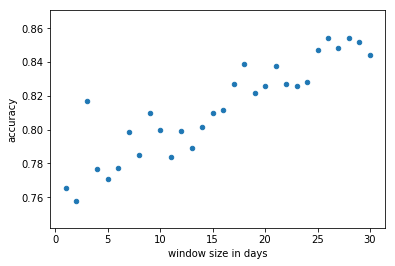

In [100]:
# Plot Accuracy vs window size
df = pd.DataFrame({"accuracy": accuracies, 
                   "window size in days":[x.days for x in window_sizes]})
df.plot(kind="scatter", y="accuracy", x="window size in days")